In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse
from matplotlib import rcParams

from tqdm.notebook import tqdm

from scipy.stats import zscore,ttest_ind,linregress
from sklearn.decomposition import PCA

rcParams['pdf.fonttype'] = 42
sns.set(context= 'talk',style='ticks',font_scale=1,rc ={'axes.spines.right': True,'axes.spines.top': True,'pdf.fonttype':42},palette='colorblind')

# Read in TPM data generated by Kallisto
* Transformed using log(x+1)

In [66]:
tpm=pd.read_csv('data/20211122_Kallisto_abundance.tsv',sep='\t',index_col=0)
tpm['cond']=[x.split('_')[1] for x in tpm['sample']]
tpm['rep']=[x.split('_')[2] for x in tpm['sample']]
tpm['time']=[int(x.split('_')[3][1:]) for x in tpm['sample']]
logtpm=tpm.loc[:,['target_id','tpm','cond','rep','time']].copy()
logtpm['logtpm']=np.log10(logtpm['tpm'].values+1)

logtpm['sample']=logtpm['cond'].values+'-'+logtpm['time'].values.astype(str)+'-'+logtpm['rep'].values
logtpm

,target_id,tpm,cond,rep,time,logtpm,sample
0,GW101-3H11_contig_1_1,2.974240,SynCom,B,95,0.599254,SynCom-95-B
1,GW101-3H11_contig_1_2,9.672920,SynCom,B,95,1.028283,SynCom-95-B
2,GW101-3H11_contig_1_3,4.544450,SynCom,B,95,0.743858,SynCom-95-B
3,GW101-3H11_contig_1_4,0.842349,SynCom,B,95,0.265372,SynCom-95-B
4,GW101-3H11_contig_1_5,0.774881,SynCom,B,95,0.249169,SynCom-95-B
...,...,...,...,...,...,...,...
9168,FW510-R12_contig_2_208,0.005991,SynCom,C,142,0.002594,SynCom-142-C
9169,FW510-R12_contig_2_209,0.016542,SynCom,C,142,0.007125,SynCom-142-C
9170,FW510-R12_contig_2_210,0.031380,SynCom,C,142,0.013419,SynCom-142-C
9171,FW510-R12_contig_2_211,0.000000,SynCom,C,142,0.000000,SynCom-142-C


# Read in organism specific EggNog annotation and KEGG reference

In [6]:
kegg=pd.read_csv('data/KEGG_Annotation_Reference.csv')
kegg

,superpathway,pathway,subpathway,enzyme,superpathway KO,pathway KO,enzyme KO,subpathway KO
0,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis,HK; hexokinase,ko09100,ko09101,K00844,ko00010
1,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis,GCK; glucokinase,ko09100,ko09101,K12407,ko00010
2,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis,glk; glucokinase,ko09100,ko09101,K00845,ko00010
3,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis,glk; glucokinase,ko09100,ko09101,K25026,ko00010
4,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis,"GPI, pgi; glucose-6-phosphate isomerase",ko09100,ko09101,K01810,ko00010
...,...,...,...,...,...,...,...,...
57525,Not Included in Pathway or Brite,Unclassified,Unclassified,K07220; uncharacterized,ko09190,ko09194,K07220,ko99997
57526,Not Included in Pathway or Brite,Unclassified,Unclassified,K07276; uncharacterized,ko09190,ko09194,K07276,ko99997
57527,Not Included in Pathway or Brite,Unclassified,Unclassified,K07338; uncharacterized,ko09190,ko09194,K07338,ko99997
57528,Not Included in Pathway or Brite,Unclassified,Unclassified,ygaC; uncharacterized,ko09190,ko09194,K07586,ko99997


In [17]:
annot_3h11=pd.read_csv('data/GW101-3H11.annotations.tsv',sep='\t')
annot_r12=pd.read_csv('data/FW510-R12.annotations.tsv',sep='\t')
annot_r12

,Query,Seed ortholog,e-value,score,best tax lvl,Preferred_name,GO terms,EC number,KEGG KO,KEGG pathway,...,KEGG rclass,BRITE,KEGG TC,CAZy,BiGG reaction,annot lvl,matching OGs,Best OG,COG cat,description
0,FW510-R12_contig_1_1,1163409.UUA_16493,1.700000e-246,858.2,Xanthomonadales,dnaA,"GO:0003674,GO:0003676,GO:0003677,GO:0003688,GO...",NaN,ko:K02313,"ko02020,ko04112,map02020,map04112",...,NaN,"ko00000,ko00001,ko03032,ko03036",NaN,NaN,NaN,Bacteria,"1MU5H@1224,1RNHP@1236,1X424@135614,COG0593@1,C...",NA|NA|NA,L,it binds specifically double-stranded DNA at a...
1,FW510-R12_contig_1_2,1163409.UUA_16488,4.500000e-197,693.7,Xanthomonadales,dnaN,NaN,2.7.7.7,ko:K02338,"ko00230,ko00240,ko01100,ko03030,ko03430,ko0344...",...,RC02795,"ko00000,ko00001,ko00002,ko01000,ko03032,ko03400",NaN,NaN,NaN,Bacteria,"1MVD9@1224,1RMNP@1236,1X3F0@135614,COG0592@1,C...",NA|NA|NA,L,Confers DNA tethering and processivity to DNA ...
2,FW510-R12_contig_1_3,1163409.UUA_16483,2.200000e-191,674.9,Xanthomonadales,recF,"GO:0000731,GO:0003674,GO:0003676,GO:0003677,GO...",NaN,ko:K03629,"ko03440,map03440",...,NaN,"ko00000,ko00001,ko03400",NaN,NaN,NaN,Bacteria,"1MX8N@1224,1RN5P@1236,1X3R9@135614,COG1195@1,C...",NA|NA|NA,L,it is required for DNA replication and normal ...
3,FW510-R12_contig_1_4,1163409.UUA_16478,0.000000e+00,1596.3,Xanthomonadales,gyrB,"GO:0000166,GO:0003674,GO:0003676,GO:0003677,GO...",5.99.1.3,ko:K02470,NaN,...,NaN,"ko00000,ko01000,ko03032,ko03400",NaN,NaN,NaN,Bacteria,"1MVKT@1224,1RNB2@1236,1X51M@135614,COG0187@1,C...",NA|NA|NA,L,A type II topoisomerase that negatively superc...
4,FW510-R12_contig_1_5,1163409.UUA_16473,8.700000e-224,782.7,Xanthomonadales,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Bacteria,"1MVH9@1224,1RQ3R@1236,1X3F2@135614,COG0457@1,C...",NA|NA|NA,S,COG0457 FOG TPR repeat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3488,FW510-R12_contig_2_195,666685.R2APBS1_1961,0.000000e+00,1385.9,Xanthomonadales,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Bacteria,"1N53E@1224,1TD3W@1236,1XA2M@135614,2CGFX@1,2Z8...",NA|NA|NA,NaN,NaN
3489,FW510-R12_contig_2_202,1234364.AMSF01000024_gene3801,2.200000e-21,109.4,Xanthomonadales,NaN,NaN,NaN,ko:K06889,NaN,...,NaN,ko00000,NaN,NaN,NaN,Bacteria,"1R1F2@1224,1T507@1236,1XDAJ@135614,COG1073@1,C...",NA|NA|NA,S,Alpha/beta hydrolase family
3490,FW510-R12_contig_2_203,1163409.UUA_16488,5.600000e-70,271.6,Xanthomonadales,dnaN,NaN,2.7.7.7,ko:K02338,"ko00230,ko00240,ko01100,ko03030,ko03430,ko0344...",...,RC02795,"ko00000,ko00001,ko00002,ko01000,ko03032,ko03400",NaN,NaN,NaN,Bacteria,"1MVD9@1224,1RMNP@1236,1X3F0@135614,COG0592@1,C...",NA|NA|NA,L,Confers DNA tethering and processivity to DNA ...
3491,FW510-R12_contig_2_209,1163409.UUA_15338,2.000000e-84,319.7,Xanthomonadales,rdgC,"GO:0000018,GO:0003674,GO:0003676,GO:0003677,GO...",NaN,ko:K03554,NaN,...,NaN,"ko00000,ko03400",NaN,NaN,NaN,Bacteria,"1MXPR@1224,1RMNN@1236,1X3BZ@135614,COG2974@1,C...",NA|NA|NA,L,May be involved in recombination


# Export tables for DESeq2 Analysis

In [18]:
count_matrix=tpm.pivot_table(index='target_id',columns='sample',values='est_counts').astype(int).fillna(0)
drop=['13_3H11_A_T71_repeat_L1', 
 '14_3H11_B_T71_repeat_L1',
 '15_3H11_C_T71_repeat_L1',
 '25_3H11_A_T95_repeat_L1', 
 '26_3H11_B_T95_repeat_L1',
 '27_3H11_C_T95_repeat_L1']
for col in count_matrix.columns:
    if 'R12' in col:
        drop.append(col)
count_matrix=count_matrix.drop(drop,axis=1)
idx=[x for x in count_matrix.index if 'R12' not in x]
count_matrix=count_matrix.loc[idx,:]
count_matrix.columns=['X_'+x[3:] for x in count_matrix.columns]
count_meta=pd.DataFrame(count_matrix.columns,columns=['sample'])
count_meta['org']=[x.split('_')[1] for x in count_meta['sample']]
count_meta['time']=[x.split('_')[3] for x in count_meta['sample']]
count_meta['rep']=[x.split('_')[2] for x in count_meta['sample']]

count_matrix.to_csv('data/DESEq_Count_Matrix_3H11.csv')
count_meta.to_csv('data/DESEq_meta_3H11.csv',index=False)
count_meta

,sample,org,time,rep
0,X_3H11_A_T42_repeat_L1,3H11,T42,A
1,X_3H11_B_T42_repeat_L1,3H11,T42,B
2,X_3H11_C_T42_repeat_L1,3H11,T42,C
3,X_SynCom_A_T42_repeat_L1,SynCom,T42,A
4,X_SynCom_B_T42_repeat_L1,SynCom,T42,B
5,X_SynCom_C_T42_repeat_L1,SynCom,T42,C
6,X_3H11_A_T53_repeat_L1,3H11,T53,A
7,X_3H11_B_T53_repeat_L1,3H11,T53,B
8,X_3H11_C_T53_repeat_L1,3H11,T53,C
9,X_SynCom_A_T53_repeat_L1,SynCom,T53,A


In [19]:
count_matrix=tpm.pivot_table(index='target_id',columns='sample',values='est_counts').astype(int).fillna(0)
drop=[]
for col in count_matrix.columns:
    if '3H11' in col:
        drop.append(col)
count_matrix=count_matrix.drop(drop,axis=1)
idx=[x for x in count_matrix.index if '3H11' not in x]
count_matrix=count_matrix.loc[idx,:]
count_matrix.columns=['X_'+x[3:] for x in count_matrix.columns]
count_meta=pd.DataFrame(count_matrix.columns,columns=['sample'])
count_meta['org']=[x.split('_')[1] for x in count_meta['sample']]
count_meta['time']=[x.split('_')[3] for x in count_meta['sample']]
count_meta['rep']=[x.split('_')[2] for x in count_meta['sample']]

count_matrix.to_csv('data/DESEq_Count_Matrix_R12.csv')
count_meta.to_csv('data/DESEq_meta_R12.csv',index=False)


# Read in DESeq2 DEG results
* Includes logfold change data and VSD transformed counts

In [81]:
vsd_3h11=pd.read_csv('data/DESeq_VSD_SynCom_vs_3H11.csv',index_col=0)
cols=[]
for x in vsd_3h11.columns:
    x=x[2:]
    cols.append(x)
vsd_3h11.columns=cols
vsd_3h11

,3H11_A_T42_repeat_L1,3H11_B_T42_repeat_L1,3H11_C_T42_repeat_L1,SynCom_A_T42_repeat_L1,SynCom_B_T42_repeat_L1,SynCom_C_T42_repeat_L1,3H11_A_T53_repeat_L1,3H11_B_T53_repeat_L1,3H11_C_T53_repeat_L1,SynCom_A_T53_repeat_L1,SynCom_B_T53_repeat_L1,SynCom_C_T53_repeat_L1,SynCom_A_T71_repeat_L1,SynCom_B_T71_repeat_L1,SynCom_C_T71_repeat_L1,SynCom_A_T95_repeat_L1,SynCom_B_T95_repeat_L1,SynCom_C_T95_repeat_L1
GW101-3H11_contig_1_1,7.986616,8.219348,8.467419,8.473218,8.611680,8.221682,5.729331,6.505083,6.440643,7.078688,7.213068,7.673363,7.182746,7.199926,7.328435,7.583546,7.612365,7.415083
GW101-3H11_contig_1_10,5.165639,5.469138,5.532331,5.929261,5.867860,5.764987,3.072702,5.470651,5.011452,4.969048,4.495072,5.487526,5.495314,4.987569,5.434887,5.258708,5.233386,5.961723
GW101-3H11_contig_1_100,4.198198,4.591861,4.138879,4.648393,4.897779,4.939974,4.384499,5.069740,5.742094,4.857075,5.410021,1.386969,5.046315,4.987569,4.868465,4.892982,5.233386,5.157190
GW101-3H11_contig_1_1000,5.829181,5.193666,5.396232,5.850149,6.075448,5.648617,5.358485,5.783531,4.323394,5.750923,6.508865,1.386969,5.256203,5.511178,5.465728,5.468391,5.072516,4.543753
GW101-3H11_contig_1_1001,4.813899,4.852005,5.077695,4.629391,5.102337,4.763624,4.640131,4.721912,4.529325,4.777199,5.165115,1.386969,4.608389,4.070135,3.813269,4.066271,4.790976,5.115052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GW101-3H11_contig_1_995,3.944108,4.480453,3.968264,5.124798,5.260026,5.015335,3.072702,4.906444,4.081658,3.725195,4.631129,1.386969,5.234349,4.656640,4.914093,5.192683,5.155217,5.521720
GW101-3H11_contig_1_996,5.560329,5.700082,5.532331,6.103059,5.936008,6.004654,5.209944,6.116602,5.821618,5.791890,5.619087,1.386969,5.747120,6.062610,6.173786,5.651265,5.570662,5.644995
GW101-3H11_contig_1_997,8.552480,8.080070,8.464813,7.240545,7.117039,7.013254,11.385030,11.239822,11.346958,8.926322,9.169331,7.360517,7.845087,8.132373,8.208421,7.786523,7.545330,7.554904
GW101-3H11_contig_1_998,6.601057,6.535124,6.472915,6.746770,7.248611,6.560196,8.511114,9.069073,9.046480,7.119414,7.830932,8.148305,7.216432,7.493393,7.286006,5.768945,6.829566,6.938359


In [83]:
vsd_r12=pd.read_csv('data/DESeq_VSD_SynCom_vs_R12.csv',index_col=0)
cols=[]
i=1
for x in vsd_r12.columns:
    x=x[2:]
    cols.append(x)
vsd_r12.columns=cols
vsd_r12

,SynCom_A_T42_repeat_L1,SynCom_B_T42_repeat_L1,SynCom_C_T42_repeat_L1,SynCom_A_T53_repeat_L1,SynCom_B_T53_repeat_L1,SynCom_C_T53_repeat_L1,SynCom_A_T71_repeat_L1,SynCom_B_T71_repeat_L1,SynCom_C_T71_repeat_L1,R12_A_T77_repeat_L1,...,R12_C_T95_repeat_L1,SynCom_A_T95_repeat_L1,SynCom_B_T95_repeat_L1,SynCom_C_T95_repeat_L1,R12_A_T119_repeat_L1,R12_B_T119_repeat_L1,R12_C_T119_repeat_L1,R12_A_T216_repeat_L1,R12_B_T216_repeat_L1,R12_C_T216_repeat_L1
FW510-R12_contig_1_1,10.952268,11.007250,10.887060,10.991381,11.052830,11.462054,11.201642,11.101570,11.289146,11.556223,...,11.189076,11.264892,11.360097,11.517266,10.998059,11.068123,11.144599,10.642662,10.666375,10.672737
FW510-R12_contig_1_10,9.833004,9.530803,9.661416,9.941261,9.690626,10.772904,10.085537,10.193392,10.375691,8.709473,...,9.930356,10.235209,10.300859,10.448994,9.994815,10.054161,10.119390,9.465735,9.656241,9.654765
FW510-R12_contig_1_100,4.245551,4.834221,5.067578,5.188973,4.258636,2.119703,4.293232,4.870600,3.671480,3.479452,...,4.030751,4.256155,3.822130,4.128058,4.211009,4.305641,4.125332,6.039200,5.524686,5.811571
FW510-R12_contig_1_1000,11.983935,12.069872,12.011160,11.786772,11.865416,11.071123,11.762348,11.818292,11.752658,11.777642,...,11.763291,11.735563,11.575711,11.645071,11.805098,11.862083,11.820935,11.960954,12.078734,12.116184
FW510-R12_contig_1_1001,8.706231,8.770812,8.454378,5.607007,6.267992,2.119703,5.299785,5.537934,5.410959,7.608153,...,5.760750,5.604670,5.615636,5.608378,5.978034,6.043627,5.393203,6.230298,6.323946,6.161303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FW510-R12_contig_2_95,6.738037,7.039211,6.643334,6.703293,7.348421,2.119703,7.144015,7.144292,7.429014,8.026209,...,8.870819,6.785142,6.638770,6.731454,6.756970,7.068277,6.903594,7.613623,7.829269,7.662045
FW510-R12_contig_2_96,9.574228,9.587421,9.498679,9.500558,9.152371,9.405763,9.307680,9.326620,9.598789,9.190729,...,9.582911,9.203199,9.219793,9.240809,9.009228,9.217139,9.451805,9.362290,9.296703,9.307829
FW510-R12_contig_2_97,8.643703,8.709339,8.858793,8.315742,7.991503,7.154668,7.431617,7.680398,7.744110,8.417705,...,8.018404,7.094248,7.781269,7.659033,7.430487,7.507939,7.363913,7.333140,7.100414,7.168590
FW510-R12_contig_2_98,9.042168,9.006276,9.055323,8.432925,8.527016,9.405763,8.007318,8.221471,8.150339,8.366145,...,8.270737,8.118725,8.089387,8.114666,8.181235,8.295123,8.426577,7.510561,7.425646,7.562244


In [27]:
reslfc=pd.read_csv('data/DESeq_ResLFC_SynCom_vs_3H11_T42.csv',index_col=0)
hits_3h11_up_1=reslfc[(reslfc.padj<=0.05)&(reslfc.log2FoldChange>=2)]
hits_3h11_down_1=reslfc[(reslfc.padj<=0.05)&(reslfc.log2FoldChange<=-2)]

reslfc=pd.read_csv('data/DESeq_ResLFC_SynCom_vs_3H11_T53.csv',index_col=0)
hits_3h11_up_2=reslfc[(reslfc.padj<=0.05)&(reslfc.log2FoldChange>=2)]
hits_3h11_down_2=reslfc[(reslfc.padj<=0.05)&(reslfc.log2FoldChange<=-2)]

reslfc=pd.read_csv('data/DESeq_ResLFC_SynCom_vs_R12_T1.csv',index_col=0)
hits_r12_up_1=reslfc[(reslfc.padj<=0.05)&(reslfc.log2FoldChange>=2)]
hits_r12_down_1=reslfc[(reslfc.padj<=0.05)&(reslfc.log2FoldChange<=-2)]

reslfc=pd.read_csv('data/DESeq_ResLFC_SynCom_vs_R12_T2.csv',index_col=0)
hits_r12_up_2=reslfc[(reslfc.padj<=0.05)&(reslfc.log2FoldChange>=2)]
hits_r12_down_2=reslfc[(reslfc.padj<=0.05)&reslfc.log2FoldChange<=-2]

reslfc=pd.read_csv('data/DESeq_ResLFC_SynCom_vs_R12_T3.csv',index_col=0)
hits_r12_up_3=reslfc[(reslfc.padj<=0.05)&(reslfc.log2FoldChange>=2)]
hits_r12_down_3=reslfc[(reslfc.padj<=0.05)&(reslfc.log2FoldChange<=-2)]

reslfc=pd.read_csv('data/DESeq_ResLFC_SynCom_vs_R12_T4.csv',index_col=0)
hits_r12_up_4=reslfc[(reslfc.padj<=0.05)&(reslfc.log2FoldChange>=2)]
hits_r12_down_4=reslfc[(reslfc.padj<=0.05)&(reslfc.log2FoldChange<=-2)]

# Identify significant DEGs, includes:
* log2 fold change >=2 or <=-2
* adjusted p-values <= 0.05

In [29]:
shared_up=list(set(hits_r12_up_1.index)&set(hits_r12_up_2.index)&set(hits_r12_up_3.index)&set(hits_r12_up_4.index))
shared_down=list(set(hits_r12_down_1.index)&set(hits_r12_down_2.index)&set(hits_r12_down_3.index)&set(hits_r12_down_4.index))
r12_up_hits=list(set(hits_r12_up_1.index)-set(shared_up))
r12_down_hits=list(set(hits_r12_down_1.index)-set(shared_down))


for df in [hits_r12_up_2,hits_r12_up_3,hits_r12_up_4]:
    r12_up_hits+=list(set(df.index)-set(r12_up_hits))
r12_up_hits+=shared_up
for df in [hits_r12_down_2,hits_r12_down_3,hits_r12_down_4]:
    r12_down_hits+=list(set(df.index)-set(r12_down_hits))
r12_down_hits+=shared_down    

shared_up=list(set(hits_3h11_up_1.index)&set(hits_3h11_up_2.index))
shared_down=list(set(hits_3h11_down_1.index)&set(hits_3h11_down_2.index))
h11_up_hits=list(set(hits_3h11_up_1.index)-set(shared_up))
h11_down_hits=list(set(hits_3h11_down_1.index)-set(shared_down))

for df in [hits_3h11_up_2]:
    h11_up_hits+=list(set(df.index)-set(h11_up_hits))
h11_up_hits+=shared_up

for df in [hits_3h11_down_2]:
    h11_down_hits+=list(set(df.index)-set(h11_down_hits))
len(h11_down_hits)
h11_down_hits+=shared_down    

In [16]:
genes=h11_up_hits+h11_down_hits
tmp=annot_3h11[annot_3h11.Query.isin(genes)].fillna('Unclassified')
genes=[]
kos=[]
for i in tmp.index:
    if 'ko' in tmp.loc[i,'KEGG KO']:
        for ko in tmp.loc[i,'KEGG KO'].split(','):
            if ':' in ko:
                kos.append(ko.split(':')[1])
            else:
                kos.append(ko)
            genes.append(tmp.loc[i,'Query'])
    else:
        kos.append(tmp.loc[i,'KEGG KO'])
        genes.append(tmp.loc[i,'Query'])
        
annot_hits_3h11=pd.DataFrame(genes,columns=['gene'])
annot_hits_3h11['enzyme KO']=kos
annot_hits_3h11=pd.merge(annot_hits_3h11,kegg,on='enzyme KO')

zvals=vsd_3h11.copy()
zvals.columns=pd.MultiIndex.from_tuples([(x.split('_')[0],x.split('_')[2]) for x in zvals.columns])
zvals=zvals.apply(zscore,axis=1)
zvals=zvals.groupby(level=[0],axis=1).mean()


annot_hits_3h11=pd.merge(annot_hits_3h11,zvals.reset_index(),left_on='gene',right_on='index').drop('index',axis=1)
annot_hits_3h11

/var/folders/kj/b6lz7n653yjc9nr6hh0bwmyc0000gp/T/ipykernel_98704/752901151.py:24: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  zvals=zvals.groupby(level=[0],axis=1).mean()


,gene,enzyme KO,superpathway,pathway,subpathway,enzyme,superpathway KO,pathway KO,subpathway KO,3H11,SynCom
0,GW101-3H11_contig_1_28,K00375,Brite Hierarchies,Protein families: genetic information processing,Transcription factors,K00375; GntR family transcriptional regulator ...,ko09180,ko09182,ko03000,0.698885,-0.349443
1,GW101-3H11_contig_1_90,K01628,Metabolism,Carbohydrate metabolism,Pentose and glucuronate interconversions,fucA; L-fuculose-phosphate aldolase,ko09100,ko09101,ko00040,-1.170557,0.585278
2,GW101-3H11_contig_1_90,K01628,Metabolism,Carbohydrate metabolism,Fructose and mannose metabolism,fucA; L-fuculose-phosphate aldolase,ko09100,ko09101,ko00051,-1.170557,0.585278
3,GW101-3H11_contig_1_90,K22130,Not Included in Pathway or Brite,Unclassified: metabolism,Enzymes with EC,otnC; 3-dehydro-4-phosphotetronate decarboxylase,ko09190,ko09191,ko99980,-1.170557,0.585278
4,GW101-3H11_contig_1_158,K00798,Metabolism,Metabolism of cofactors and vitamins,Porphyrin metabolism,"MMAB, pduO; cob(I)alamin adenosyltransferase",ko09100,ko09108,ko00860,-0.857228,0.428614
...,...,...,...,...,...,...,...,...,...,...,...
498,GW101-3H11_contig_1_4912,K00925,Metabolism,Carbohydrate metabolism,Pyruvate metabolism,ackA; acetate kinase,ko09100,ko09101,ko00620,-1.094589,0.547295
499,GW101-3H11_contig_1_4912,K00925,Metabolism,Carbohydrate metabolism,Propanoate metabolism,ackA; acetate kinase,ko09100,ko09101,ko00640,-1.094589,0.547295
500,GW101-3H11_contig_1_4912,K00925,Metabolism,Energy metabolism,Carbon fixation pathways in prokaryotes,ackA; acetate kinase,ko09100,ko09102,ko00720,-1.094589,0.547295
501,GW101-3H11_contig_1_4912,K00925,Metabolism,Energy metabolism,Methane metabolism,ackA; acetate kinase,ko09100,ko09102,ko00680,-1.094589,0.547295


In [15]:
genes=r12_up_hits+r12_down_hits
tmp=annot_r12[annot_r12.Query.isin(genes)].fillna('Unclassified')
genes=[]
kos=[]
for i in tmp.index:
    if 'ko' in tmp.loc[i,'KEGG KO']:
        for ko in tmp.loc[i,'KEGG KO'].split(','):
            if ':' in ko:
                kos.append(ko.split(':')[1])
            else:
                kos.append(ko)
            genes.append(tmp.loc[i,'Query'])
    else:
        kos.append(tmp.loc[i,'KEGG KO'])
        genes.append(tmp.loc[i,'Query'])
        
annot_hits_r12=pd.DataFrame(genes,columns=['gene'])
annot_hits_r12['enzyme KO']=kos
annot_hits_r12=pd.merge(annot_hits_r12,kegg,on='enzyme KO')

zvals=vsd_r12.copy()
zvals.columns=pd.MultiIndex.from_tuples([(x.split('_')[0],x.split('_')[2]) for x in zvals.columns])
zvals=zvals.apply(zscore,axis=1)
zvals=zvals.groupby(level=[0],axis=1).mean()


annot_hits_r12=pd.merge(annot_hits_r12,zvals.reset_index(),left_on='gene',right_on='index').drop('index',axis=1)
annot_hits_r12

/var/folders/kj/b6lz7n653yjc9nr6hh0bwmyc0000gp/T/ipykernel_98704/751766318.py:24: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  zvals=zvals.groupby(level=[0],axis=1).mean()


,gene,enzyme KO,superpathway,pathway,subpathway,enzyme,superpathway KO,pathway KO,subpathway KO,R12,SynCom
0,FW510-R12_contig_1_4,K02470,Brite Hierarchies,Protein families: genetic information processing,DNA replication proteins,gyrB; DNA gyrase subunit B,ko09180,ko09182,ko03032,-0.244135,0.244135
1,FW510-R12_contig_1_4,K02470,Brite Hierarchies,Protein families: genetic information processing,DNA repair and recombination proteins,gyrB; DNA gyrase subunit B,ko09180,ko09182,ko03400,-0.244135,0.244135
2,FW510-R12_contig_1_6,K03832,Brite Hierarchies,Protein families: signaling and cellular proce...,Transporters,tonB; periplasmic protein,ko09180,ko09183,ko02000,-0.202806,0.202806
3,FW510-R12_contig_1_6,K07126,Not Included in Pathway or Brite,Unclassified,Unclassified,K07126; uncharacterized,ko09190,ko09194,ko99997,-0.202806,0.202806
4,FW510-R12_contig_1_7,K03561,Brite Hierarchies,Protein families: signaling and cellular proce...,Transporters,exbB; biopolymer transport protein,ko09180,ko09183,ko02000,-0.344828,0.344828
...,...,...,...,...,...,...,...,...,...,...,...
903,FW510-R12_contig_1_3562,K03536,Brite Hierarchies,Protein families: genetic information processing,Transfer RNA biogenesis,rnpA; ribonuclease P protein component,ko09180,ko09182,ko03016,-0.266004,0.266004
904,FW510-R12_contig_1_3562,K08998,Not Included in Pathway or Brite,Unclassified,Unclassified,K08998; uncharacterized,ko09190,ko09194,ko99997,-0.266004,0.266004
905,FW510-R12_contig_1_3563,K02914,Genetic Information Processing,Translation,Ribosome,"RP-L34, MRPL34, rpmH; large subunit ribosomal ...",ko09120,ko09122,ko03010,-0.325398,0.325398
906,FW510-R12_contig_1_3563,K02914,Brite Hierarchies,Protein families: genetic information processing,Ribosome,"RP-L34, MRPL34, rpmH; large subunit ribosomal ...",ko09180,ko09182,ko03011,-0.325398,0.325398


In [19]:
tmp=annot_3h11.fillna('Unclassified')
genes=[]
kos=[]
for i in tmp.index:
    if 'ko' in tmp.loc[i,'KEGG KO']:
        for ko in tmp.loc[i,'KEGG KO'].split(','):
            if ':' in ko:
                kos.append(ko.split(':')[1])
            else:
                kos.append(ko)
            genes.append(tmp.loc[i,'Query'])
    else:
        kos.append(tmp.loc[i,'KEGG KO'])
        genes.append(tmp.loc[i,'Query'])
        
annot_full_3h11=pd.DataFrame(genes,columns=['gene'])
annot_full_3h11['enzyme KO']=kos
annot_full_3h11=pd.merge(annot_full_3h11,kegg,on='enzyme KO')
annot_full_3h11

,gene,enzyme KO,superpathway,pathway,subpathway,enzyme,superpathway KO,pathway KO,subpathway KO
0,GW101-3H11_contig_1_1,K02313,Environmental Information Processing,Signal transduction,Two-component system,dnaA; chromosomal replication initiator,ko09130,ko09132,ko02020
1,GW101-3H11_contig_1_1,K02313,Cellular Processes,Cell growth and death,Cell cycle - Caulobacter,dnaA; chromosomal replication initiator,ko09140,ko09143,ko04112
2,GW101-3H11_contig_1_1,K02313,Brite Hierarchies,Protein families: genetic information processing,DNA replication proteins,dnaA; chromosomal replication initiator,ko09180,ko09182,ko03032
3,GW101-3H11_contig_1_1,K02313,Brite Hierarchies,Protein families: genetic information processing,Chromosome and associated proteins,dnaA; chromosomal replication initiator,ko09180,ko09182,ko03036
4,GW101-3H11_contig_1_2,K02338,Genetic Information Processing,Replication and repair,DNA replication,dnaN; DNA polymerase III subunit beta,ko09120,ko09124,ko03030
...,...,...,...,...,...,...,...,...,...
8187,GW101-3H11_contig_1_4954,K08998,Not Included in Pathway or Brite,Unclassified,Unclassified,K08998; uncharacterized,ko09190,ko09194,ko99997
8188,GW101-3H11_contig_1_4955,K03536,Brite Hierarchies,Protein families: genetic information processing,Transfer RNA biogenesis,rnpA; ribonuclease P protein component,ko09180,ko09182,ko03016
8189,GW101-3H11_contig_1_4955,K08998,Not Included in Pathway or Brite,Unclassified,Unclassified,K08998; uncharacterized,ko09190,ko09194,ko99997
8190,GW101-3H11_contig_1_4956,K02914,Genetic Information Processing,Translation,Ribosome,"RP-L34, MRPL34, rpmH; large subunit ribosomal ...",ko09120,ko09122,ko03010


In [20]:
tmp=annot_r12.fillna('Unclassified')
genes=[]
kos=[]
for i in tmp.index:
    if 'ko' in tmp.loc[i,'KEGG KO']:
        for ko in tmp.loc[i,'KEGG KO'].split(','):
            if ':' in ko:
                kos.append(ko.split(':')[1])
            else:
                kos.append(ko)
            genes.append(tmp.loc[i,'Query'])
    else:
        kos.append(tmp.loc[i,'KEGG KO'])
        genes.append(tmp.loc[i,'Query'])
        
annot_full_r12=pd.DataFrame(genes,columns=['gene'])
annot_full_r12['enzyme KO']=kos
annot_full_r12=pd.merge(annot_full_r12,kegg,on='enzyme KO')
annot_full_r12

,gene,enzyme KO,superpathway,pathway,subpathway,enzyme,superpathway KO,pathway KO,subpathway KO
0,FW510-R12_contig_1_1,K02313,Environmental Information Processing,Signal transduction,Two-component system,dnaA; chromosomal replication initiator,ko09130,ko09132,ko02020
1,FW510-R12_contig_1_1,K02313,Cellular Processes,Cell growth and death,Cell cycle - Caulobacter,dnaA; chromosomal replication initiator,ko09140,ko09143,ko04112
2,FW510-R12_contig_1_1,K02313,Brite Hierarchies,Protein families: genetic information processing,DNA replication proteins,dnaA; chromosomal replication initiator,ko09180,ko09182,ko03032
3,FW510-R12_contig_1_1,K02313,Brite Hierarchies,Protein families: genetic information processing,Chromosome and associated proteins,dnaA; chromosomal replication initiator,ko09180,ko09182,ko03036
4,FW510-R12_contig_1_2,K02338,Genetic Information Processing,Replication and repair,DNA replication,dnaN; DNA polymerase III subunit beta,ko09120,ko09124,ko03030
...,...,...,...,...,...,...,...,...,...
6199,FW510-R12_contig_2_203,K02338,Brite Hierarchies,Protein families: genetic information processing,DNA replication proteins,dnaN; DNA polymerase III subunit beta,ko09180,ko09182,ko03032
6200,FW510-R12_contig_2_203,K02338,Brite Hierarchies,Protein families: genetic information processing,DNA repair and recombination proteins,dnaN; DNA polymerase III subunit beta,ko09180,ko09182,ko03400
6201,FW510-R12_contig_2_209,K03554,Brite Hierarchies,Protein families: genetic information processing,DNA repair and recombination proteins,rdgC; recombination associated protein,ko09180,ko09182,ko03400
6202,FW510-R12_contig_2_212,K03981,Brite Hierarchies,Protein families: genetic information processing,Chaperones and folding catalysts,dsbC; thiol:disulfide interchange protein DsbC,ko09180,ko09182,ko03110


# Look at transcript relative abundance 
* Analysis identified issues with 3H11 samples >T53. Despite confidence in culture purity significant number of non-rRNA transcripts map to R12. Seems to be related to low mRNA abundance (low non-rRNA transcript total counts).
* No issues with R12 samples, unclear if issues are present in SynCom samples but assumption is they are ok due to high overall counts


In [36]:
gw101_nc=4956
fw510_nc=3562

nc_genes=[]
for i in tpm.target_id.unique():
    if 'GW101' in i and 'contig_1' in i:
        g_num=int(i.split('_')[-1])
        if g_num > gw101_nc:
            nc_genes.append(i)
    elif 'FW510' in i and 'contig_1' in i:
        g_num=int(i.split('_')[-1])
        if g_num > fw510_nc:
            nc_genes.append(i)
nc_genes

['GW101-3H11_contig_1_4957',
 'GW101-3H11_contig_1_4958',
 'GW101-3H11_contig_1_4959',
 'GW101-3H11_contig_1_4960',
 'GW101-3H11_contig_1_4961',
 'GW101-3H11_contig_1_4962',
 'GW101-3H11_contig_1_4963',
 'GW101-3H11_contig_1_4964',
 'GW101-3H11_contig_1_4965',
 'GW101-3H11_contig_1_4966',
 'GW101-3H11_contig_1_4967',
 'GW101-3H11_contig_1_4968',
 'GW101-3H11_contig_1_4969',
 'GW101-3H11_contig_1_4970',
 'GW101-3H11_contig_1_4971',
 'GW101-3H11_contig_1_4972',
 'GW101-3H11_contig_1_4973',
 'GW101-3H11_contig_1_4974',
 'GW101-3H11_contig_1_4975',
 'GW101-3H11_contig_1_4976',
 'GW101-3H11_contig_1_4977',
 'GW101-3H11_contig_1_4978',
 'GW101-3H11_contig_1_4979',
 'GW101-3H11_contig_1_4980',
 'GW101-3H11_contig_1_4981',
 'GW101-3H11_contig_1_4982',
 'GW101-3H11_contig_1_4983',
 'GW101-3H11_contig_1_4984',
 'GW101-3H11_contig_1_4985',
 'GW101-3H11_contig_1_4986',
 'GW101-3H11_contig_1_4987',
 'GW101-3H11_contig_1_4988',
 'GW101-3H11_contig_1_4989',
 'GW101-3H11_contig_1_4990',
 'GW101-3H11_c

In [37]:
df=tpm[~tpm.target_id.isin(nc_genes)].copy()
df['org']=[x.split('_')[0].split('-')[1] for x in df.target_id]
relabund=df.fillna(0).groupby(by=['sample','org']).sum()['tpm'].reset_index()
relabund['rel']=relabund['tpm']/10**6
relabund['cond']=[x.split('_')[1] for x in relabund['sample']]
relabund['rep']=[x.split('_')[2] for x in relabund['sample']]
relabund['time']=[int(x.split('_')[3][1:-1]) for x in relabund['sample']]
relabund

,sample,org,tpm,rel,cond,rep,time
0,01_3H11_A_T42_repeat_L1,3H11,98319.390202,0.098319,3H11,A,4
1,01_3H11_A_T42_repeat_L1,R12,156.249067,0.000156,3H11,A,4
2,02_3H11_B_T42_repeat_L1,3H11,52484.458345,0.052484,3H11,B,4
3,02_3H11_B_T42_repeat_L1,R12,35.310256,0.000035,3H11,B,4
4,03_3H11_C_T42_repeat_L1,3H11,109875.341388,0.109875,3H11,C,4
...,...,...,...,...,...,...,...
73,37_R12_A_T216_repeat_L1,R12,224116.196627,0.224116,R12,A,21
74,38_R12_B_T216_repeat_L1,3H11,9.662621,0.000010,R12,B,21
75,38_R12_B_T216_repeat_L1,R12,227486.817466,0.227487,R12,B,21
76,39_R12_C_T216_repeat_L1,3H11,9.130808,0.000009,R12,C,21


(-0.5, 2.5)

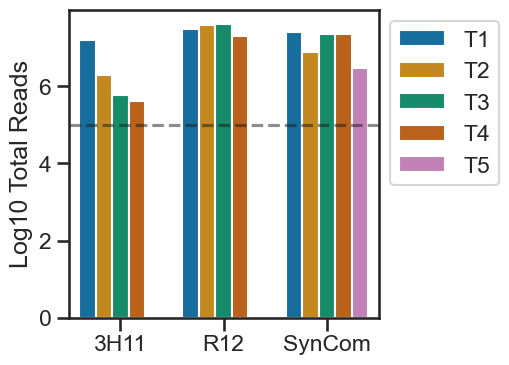

In [38]:
temp=tpm[~tpm.target_id.isin(nc_genes)].groupby(by=['cond','time']).sum().reset_index()
temp['log_counts']=np.log10(temp['est_counts'])
temp['Timepoint']=['T1','T2','T3','T4','T1','T2','T3','T4','T1','T2','T3','T4','T5']
plt.figure(figsize=(4,4))
sns.barplot(x='cond',y='log_counts',hue='Timepoint',data=temp)
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Log10 Total Reads')
plt.xlabel('')
xlim=plt.xlim()
plt.plot(xlim,(5,5),'k--',alpha=0.5)
plt.xlim(xlim)
#temp

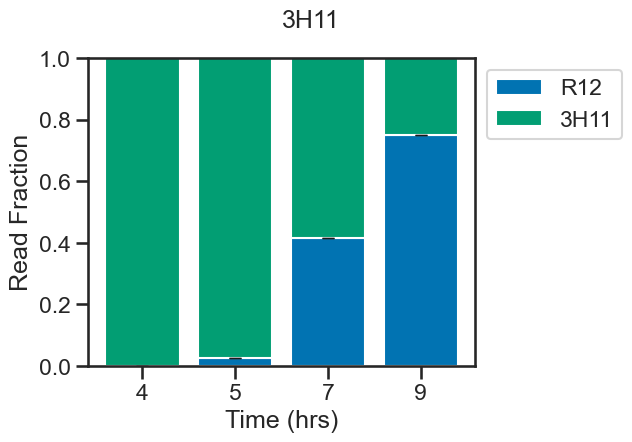

<Figure size 640x480 with 0 Axes>

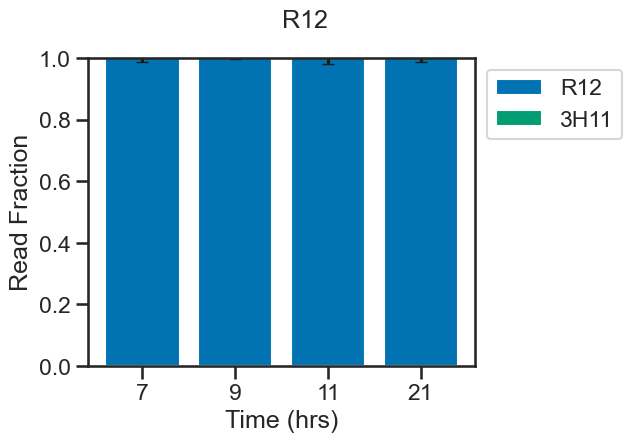

<Figure size 640x480 with 0 Axes>

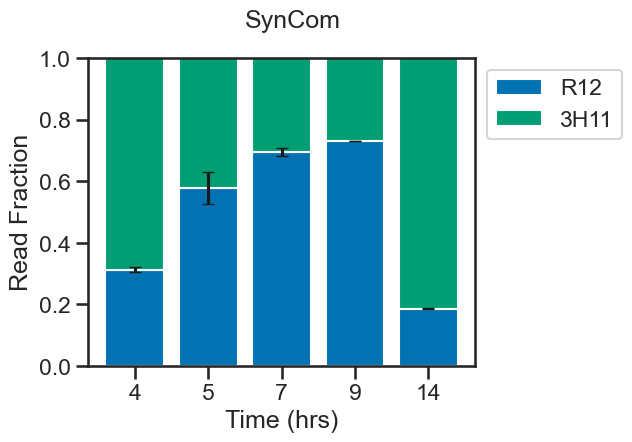

<Figure size 640x480 with 0 Axes>

In [47]:
for idx,df in relabund.groupby(by='cond'):
    df['time'] = [int(x) for x in df['time']]
    mean=df[['org','time','rel','tpm']].groupby(by=['org','time']).mean()
    mean=mean/mean.groupby(by='time').sum()
    std=df[['org','time','rel','tpm']].groupby(by=['org','time']).std()
    plt.figure(figsize=(5,4))
    plt.bar(range(len(mean.index.levels[1])),mean.loc['R12','rel'].values,label='R12',yerr=std.loc['R12','rel'].values,capsize=4)
    plt.bar(range(len(mean.index.levels[1])),mean.loc['3H11','rel'].values,bottom=mean.loc['R12','rel'].values,color='g',label='3H11')
    #plt.fill_between(mean.index,mean.values-std.values,mean.values+std.values,alpha=0.5)
    plt.xlabel('Time (hrs)')
    plt.ylabel('Read Fraction')
    plt.xticks(range(len(mean.index.levels[1])),mean.index.levels[1])
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(1,1))
    plt.text(1.5,1.1,idx)
    #plt.savefig(idx+'-Transcript-Relabund.png',dpi=500,bbox_inches='tight')
    plt.show()
    plt.clf()
    


In [53]:
gw101_rfam=pd.read_csv('data/GW101-3H11_Rfam.gff',sep='\t',header=None)
indxs=[]
j=0
for i in gw101_rfam[0].values:
    indxs.append('%s_%s'%(i,gw101_nc+j))
    j+=1
gw101_rfam.index=indxs
rna_dict=gw101_rfam[2].to_dict()
fw510_rfam=pd.read_csv('data/FW510-R12_Rfam.gff',sep='\t',header=None)
indxs=[]
j=0
for i in fw510_rfam[0].values:
    indxs.append('%s_%s'%(i,fw510_nc+j))
    j+=1
fw510_rfam.index=indxs
rna_dict2=fw510_rfam[2].to_dict()
rna_dict.update(rna_dict2)
rna_dict

{'GW101-3H11_contig_1_4956': '5S_rRNA',
 'GW101-3H11_contig_1_4957': '5S_rRNA',
 'GW101-3H11_contig_1_4958': '5S_rRNA',
 'GW101-3H11_contig_1_4959': '5S_rRNA',
 'GW101-3H11_contig_1_4960': 'tRNA',
 'GW101-3H11_contig_1_4961': 'tRNA',
 'GW101-3H11_contig_1_4962': 'tRNA',
 'GW101-3H11_contig_1_4963': 'tRNA',
 'GW101-3H11_contig_1_4964': 'tRNA',
 'GW101-3H11_contig_1_4965': 'tRNA',
 'GW101-3H11_contig_1_4966': 'tRNA',
 'GW101-3H11_contig_1_4967': 'tRNA',
 'GW101-3H11_contig_1_4968': 'tRNA',
 'GW101-3H11_contig_1_4969': 'tRNA',
 'GW101-3H11_contig_1_4970': 'tRNA',
 'GW101-3H11_contig_1_4971': 'tRNA',
 'GW101-3H11_contig_1_4972': 'tRNA',
 'GW101-3H11_contig_1_4973': 'tRNA',
 'GW101-3H11_contig_1_4974': 'tRNA',
 'GW101-3H11_contig_1_4975': 'tRNA',
 'GW101-3H11_contig_1_4976': 'tRNA',
 'GW101-3H11_contig_1_4977': 'tRNA',
 'GW101-3H11_contig_1_4978': 'tRNA',
 'GW101-3H11_contig_1_4979': 'tRNA',
 'GW101-3H11_contig_1_4980': 'tRNA',
 'GW101-3H11_contig_1_4981': 'tRNA',
 'GW101-3H11_contig_1_4982

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/660773677.py:2: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  plt.hist(logtpm[(logtpm.cond=='R12')&([True if 'R12' in x else False for x in logtpm.target_id])].logtpm.values,bins=25)


(0.0, 8000.0)

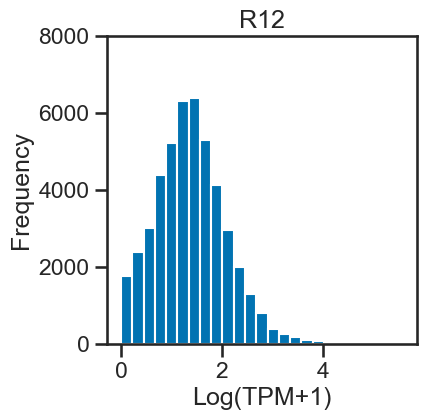

In [63]:
plt.figure(figsize=(4,4))
plt.hist(logtpm[(logtpm.cond=='R12')&([True if 'R12' in x else False for x in logtpm.target_id])].logtpm.values,bins=25)
plt.xlabel('Log(TPM+1)')
plt.title('R12')
plt.ylabel('Frequency')
plt.ylim(0,8000)
#plt.savefig('R12-logTPM-Dist.png',dpi=500,bbox_inches='tight')

Text(0.5, 1.0, 'R12')

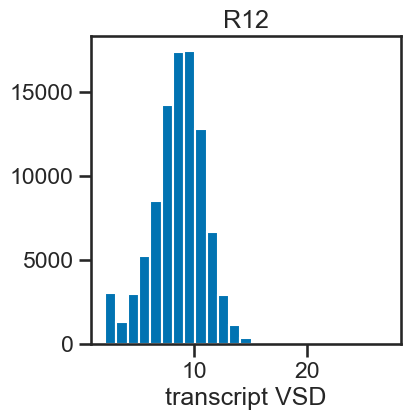

In [93]:
plt.figure(figsize=(4,4))
x=vsd_r12.values.ravel()
plt.hist(x,bins=25)
plt.xlabel('transcript VSD')
plt.title('R12')

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/1359791051.py:2: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  plt.hist(logtpm[(logtpm.cond=='3H11')&([True if '3H11' in x else False for x in logtpm.target_id])].logtpm.values,bins=25)


(0.0, 8000.0)

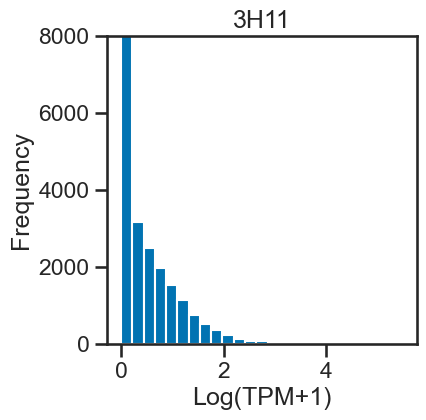

In [64]:
plt.figure(figsize=(4,4))
plt.hist(logtpm[(logtpm.cond=='3H11')&([True if '3H11' in x else False for x in logtpm.target_id])].logtpm.values,bins=25)
plt.xlabel('Log(TPM+1)')
plt.title('3H11')
plt.ylabel('Frequency')
plt.ylim(0,8000)

Text(0.5, 1.0, '3H11')

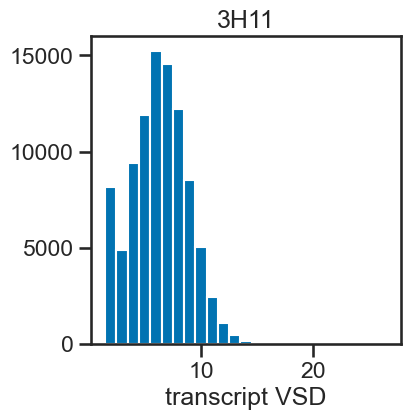

In [92]:
plt.figure(figsize=(4,4))
x=vsd_3h11.values.ravel()
plt.hist(x,bins=25)
plt.xlabel('transcript VSD')
plt.title('3H11')

# Look at growth data
* Black triangles indicate times where samples were collected for RNA-seq

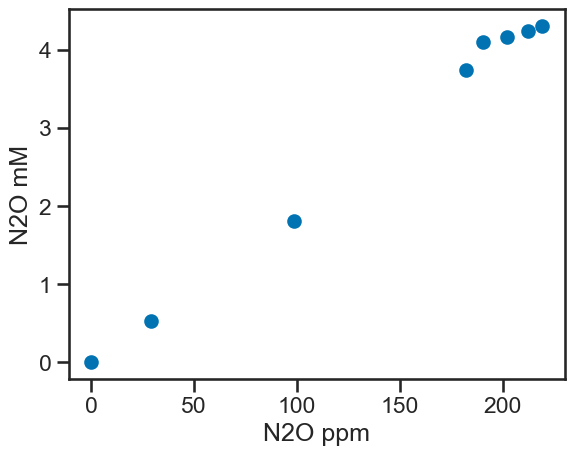

In [72]:
gcdata=pd.read_excel('data/RNASeq_SynCom_BaseLine.xlsx',sheet_name='GC')
gcdata['cond']=[x.split('_')[1] for x in gcdata['Sample Name']]
gc=gcdata[gcdata.cond=='R12']
mean=gc[['Time','Nitrous Oxide']].groupby(by='Time').mean()
x=[0]+list(mean.values[-7:].ravel())
from scipy.stats import linregress
y=[0,0.53,1.81,4.102,4.246,4.30,4.16,3.74]
plt.scatter(x,y)
plt.xlabel('N2O ppm')
plt.ylabel('N2O mM')
fit=linregress(x,y)
gcdata['N2O (mM)']= gcdata['Nitrous Oxide']*fit.slope+fit.intercept

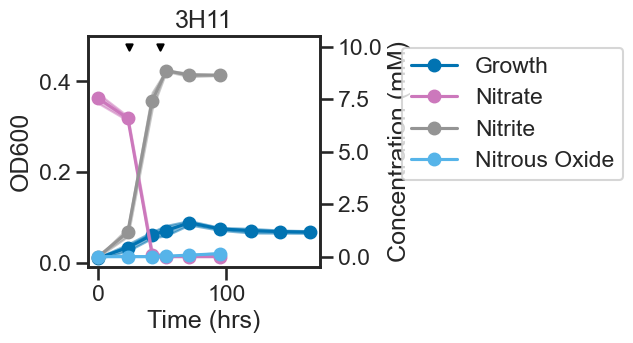

<Figure size 640x480 with 0 Axes>

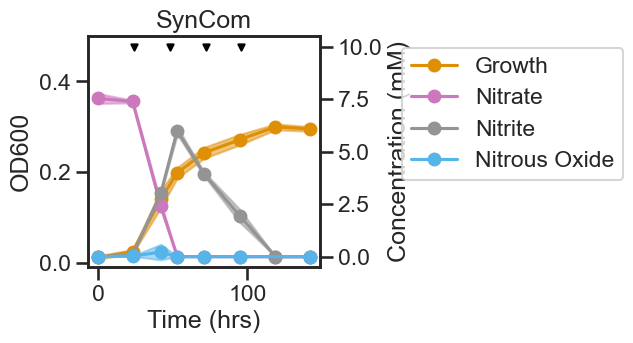

<Figure size 640x480 with 0 Axes>

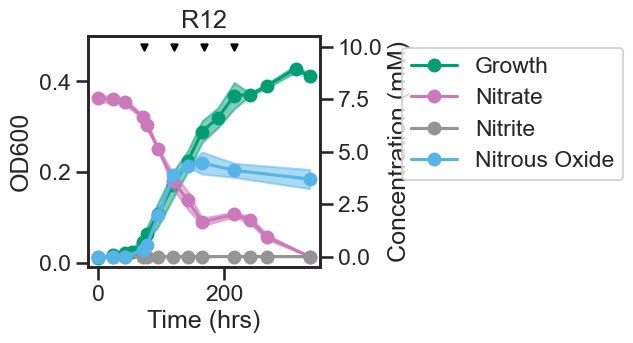

<Figure size 640x480 with 0 Axes>

In [73]:
sns.set(context= 'talk',style='ticks',font_scale=1,rc ={'axes.spines.right': True,'axes.spines.top': True},palette='colorblind')
gallery=pd.read_excel('data/RNASeq_SynCom_BaseLine.xlsx',sheet_name='Gallery')
gallery['cond']=[x.split('-')[0] for x in gallery['Sample']]
colors=sns.color_palette('colorblind')
growth = pd.DataFrame()
time_points={'3H11':[24,48],'R12':[72,120,168,168+48],'SynCom':[24,48,72,96]}
j=0
for org in ['3H11','SynCom','R12']:
    handles=[]
    growthdata=pd.read_excel('data/RNASeq_SynCom_BaseLine.xlsx',sheet_name=org)
    growthdata.index=[org+'-'+str(x+1) for x in growthdata.index]
    growth=pd.concat([growth,growthdata])
    mean=growthdata.mean(axis=0)
    std=growthdata.std(axis=0)
    
    df=growthdata.stack().reset_index()
    df.columns=['condition','hrs','OD']
    df['rep']=[x.split('-')[1] for x in df['condition']]
    df['condition']=[x.split('-')[0] for x in df['condition']]
    
    fig,ax1 = plt.subplots(1,1,figsize=(3,3))
    plot,=ax1.plot(mean.index,mean,marker='o',color=colors[j],label='Growth')
    handles.append(plot)
    ax1.fill_between(mean.index,mean-std,mean+std,alpha=0.5,color=colors[j])
    j+=1

    gal =gallery[gallery.cond==org].fillna(0)
    gal['Nitrate (mM)']= gal['TON (mM)']-gal['Nitrite (mM)']
    gal=gal.drop(['cond','Sample'],axis=1)
    gal[gal<0]=0

    i=4
    mean=gal.groupby(by=['Time']).mean()
    std=gal.groupby(by=['Time']).std()
    ax2=ax1.twinx()
    for col in ['Nitrate (mM)','Nitrite (mM)']:
        plot,=ax2.plot(mean.index,mean[col],marker='o',color=colors[i],label=col.split()[0])
        handles.append(plot)
        ax2.fill_between(mean.index,mean[col]-std[col],mean[col]+std[col],alpha=0.5,color=colors[i])
        i+=3


    gc=gcdata[gcdata.cond==org]
    gc=gc.drop(['Sample Name','cond'],axis=1)
    gc[gc<0]=0
    mean=gc.groupby(by='Time').mean()
    std=gc.groupby(by='Time').std()

    col='N2O (mM)'
    mean.loc[0,col]=0
    std.loc[0,col]=0
    mean=mean.sort_index()
    std=std.sort_index()
    plot,=ax2.plot(mean.index,mean[col],marker='o',color=colors[-1],label=col.split()[0])
    handles.append(plot)
    ax2.fill_between(mean.index,mean[col]-std[col],mean[col]+std[col],alpha=0.5,color=colors[-1])
    time = time_points[org]
    for t in time:
        ax2.scatter(t,10,marker='v',color='black',s=20)
    ax2.set_ylabel('Concentration (mM)')
    ax1.set_ylabel('OD600')
    ax1.set_xlabel('Time (hrs)')
    ax1.set_title(org)
    ax2.legend(handles,['Growth','Nitrate','Nitrite','Nitrous Oxide'],bbox_to_anchor=(1.3,1),loc=2)
    ax1.set_ylim(-.01,.5)
    ax2.set_ylim(-.5,10.5)
    #ax2.set_xlim(0,250)
    #ax1.set_xlim(0,250)
    plt.show()
    plt.clf()

In [76]:
growth.index=pd.MultiIndex.from_tuples(x.split('-') for x in growth.index)

mean=growth.groupby(level=0).mean()
std=growth.groupby(level=0).std()
mean_high=mean+std
mean_low=mean-std

mean.index=pd.MultiIndex.from_tuples((x,1) for x in mean.index)
mean_low.index=pd.MultiIndex.from_tuples((x,2) for x in mean_low.index)
mean_high.index=pd.MultiIndex.from_tuples((x,3) for x in mean_high.index)

df=pd.concat([mean,mean_low,mean_high])

w=3
res={}
for i in range(len(df)-w+1):
    x=df.columns[i:i+w].values
    for idx in df.index.values:
        y= np.log2(df.loc[idx,x])
        r= linregress(x,y)
        if idx not in res:
            res[idx]=[]
        res[idx].append(r.slope)
        
res=pd.DataFrame(res)
res=res.max().reset_index()
res.columns=['org','rep','rate']
res

,org,rep,rate
0,3H11,1,0.062130
1,R12,1,0.051291
2,SynCom,1,0.104851
3,3H11,2,0.063549
4,R12,2,0.052535
5,SynCom,2,0.111694
6,3H11,3,0.061045
7,R12,3,0.050567
8,SynCom,3,0.099553


Text(0, 0.5, 'Max specific rate \n(1/hr)')

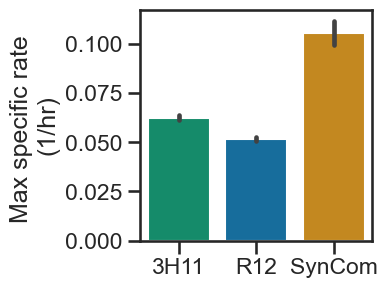

In [77]:
colors=sns.color_palette('colorblind')
colors=[colors[2],colors[0],colors[1]]
plt.figure(figsize=(3,3))
sns.barplot(x='org',y='rate',hue='org',data=res,order=['3H11','R12','SynCom'],palette=colors)
plt.xlabel('')
plt.ylabel('Max specific rate \n(1/hr)')
#plt.savefig('Growth-rates-barplot-v2.pdf',bbox_inches='tight')

# PCA
* Look at global transcript trends of isolates in monoculture vs SynCom
* Use VSD transcript counts and isolate specific transcripts across conditons

In [94]:

def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/3514035674.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['T1' 'T1' 'T1' 'T2' 'T2' 'T2']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pca_df.loc[idx,'time']=new_times


(-50.0, 75.0)

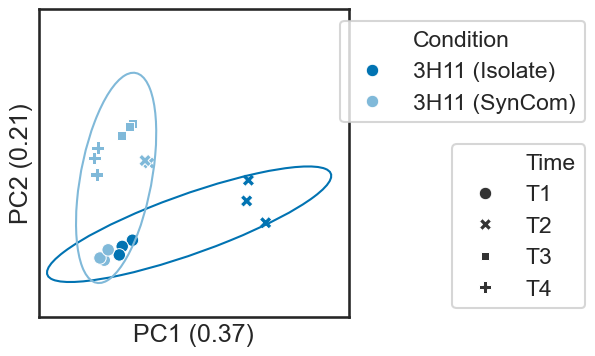

In [98]:

genes=annot_3h11.loc[annot_3h11['KEGG pathway'].dropna().index.values].Query.values
h11=vsd_3h11.loc[genes].T.drop('SynCom_C_T53_repeat_L1')
#r12=np.log10(r12+1)
zvals=h11.apply(zscore)
pca = PCA(n_components=3)
res = pca.fit_transform(zvals.dropna(axis=1))
colors=sns.color_palette('colorblind')
colors=[colors[0]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)
pca_df = pd.DataFrame(data = res, columns = ['PC1', 'PC2','PC3'])
pca_df['sample']=zvals.index.values
pca_df['cond']=[x.split('_')[0] for x in pca_df['sample']]
pca_df['rep']=[x.split('_')[1] for x in pca_df['sample']]
pca_df['time']=[int(x.split('_')[2][1:]) for x in pca_df['sample']]
#pca_df=pca_df.drop([12,13,14,18,19,20],axis=0)
time_dict={42:'T1',53:'T2',71:'T3',95:'T4'}
new_times=pca_df[pca_df.cond=='3H11'].time.map(time_dict)
idx=pca_df[pca_df.cond=='3H11'].index
pca_df.loc[idx,'time']=new_times

new_times=pca_df[pca_df.cond=='SynCom'].time.map(time_dict)
idx=pca_df[pca_df.cond=='SynCom'].index
pca_df.loc[idx,'time']=new_times

fig,ax =plt.subplots(1,1,figsize=(4,4))
g=sns.scatterplot(x='PC1',y='PC2',data=pca_df,hue='cond',style='time',palette=colors,ax=ax)
handles, labels = g.get_legend_handles_labels()
g.legend(bbox_to_anchor=(1,1))


df=pca_df[pca_df.cond=='3H11']
x=df.PC1
y=df.PC2
confidence_ellipse(x, y, ax, edgecolor=colors[0])

df=pca_df[pca_df.cond=='SynCom']
x=df.PC1
y=df.PC2
confidence_ellipse(x, y, ax, edgecolor=colors[1])

#plt.ylim(-75,75)
#plt.xlim(-125,125)
plt.xticks([])
plt.yticks([])
g.legend('',frameon=False)
plt.xlabel('PC1 (%s)'%(pca.explained_variance_ratio_[0].round(2)))
plt.ylabel('PC2 (%s)'%(pca.explained_variance_ratio_[1].round(2)))
leg1=g.legend(handles[:3],['','3H11 (Isolate)', '3H11 (SynCom)'],bbox_to_anchor=(1.8,1))
leg2=g.legend(handles[3:],labels[3:],bbox_to_anchor=(1.8,.6)).get_texts()[0].set_text('Time')
g.add_artist(leg1).get_texts()[0].set_text('Condition')
plt.xlim(-50,100)
plt.ylim(-50,75)
#plt.savefig('3H11-SynCom-PCA-v3.png',dpi=500,bbox_inches='tight')
#plt.savefig('3H11-SynCom-PCA-v3.pdf',bbox_inches='tight')

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/1168880606.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['T1' 'T1' 'T1' 'T2' 'T2' 'T3' 'T3' 'T3' 'T4' 'T4' 'T4']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pca_df.loc[idx,'time']=new_times


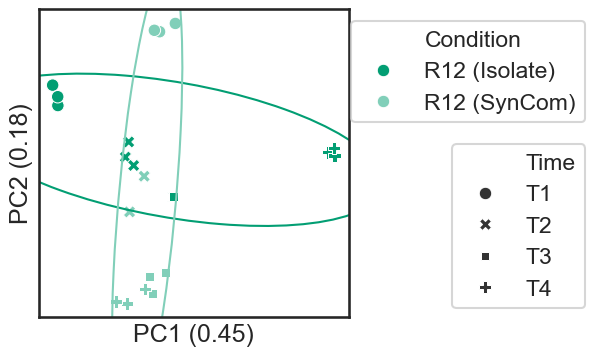

In [101]:

genes=annot_r12.loc[annot_r12['KEGG pathway'].dropna().index.values].Query.values
h11=vsd_r12.loc[genes].T.drop('SynCom_C_T53_repeat_L1')
#r12=np.log10(r12+1)
zvals=h11.apply(zscore)
pca = PCA(n_components=3)
res = pca.fit_transform(zvals.dropna(axis=1))
colors=sns.color_palette('colorblind')
colors=[colors[2]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)
pca_df = pd.DataFrame(data = res, columns = ['PC1', 'PC2','PC3'])
pca_df['sample']=zvals.index.values
pca_df['cond']=[x.split('_')[0] for x in pca_df['sample']]
pca_df['rep']=[x.split('_')[1] for x in pca_df['sample']]
pca_df['time']=[int(x.split('_')[2][1:]) for x in pca_df['sample']]
#pca_df=pca_df.drop([12,13,14,18,19,20],axis=0)
time_dict={42:'T1',53:'T2',71:'T3',95:'T4'}
new_times=pca_df[pca_df.cond=='SynCom'].time.map(time_dict)
idx=pca_df[pca_df.cond=='SynCom'].index
pca_df.loc[idx,'time']=new_times

time_dict={77:'T1',95:'T2',119:'T3',216:'T4'}
new_times=pca_df[pca_df.cond=='R12'].time.map(time_dict)
idx=pca_df[pca_df.cond=='R12'].index
pca_df.loc[idx,'time']=new_times

fig,ax =plt.subplots(1,1,figsize=(4,4))
g=sns.scatterplot(x='PC1',y='PC2',data=pca_df,hue='cond',style='time',palette=colors,ax=ax,hue_order=['R12','SynCom'])
handles, labels = g.get_legend_handles_labels()
#g.legend(bbox_to_anchor=(1,1))


df=pca_df[pca_df.cond=='R12']
x=df.PC1
y=df.PC2
confidence_ellipse(x, y, ax, edgecolor=colors[0])

df=pca_df[pca_df.cond=='SynCom']
x=df.PC1
y=df.PC2
confidence_ellipse(x, y, ax, edgecolor=colors[1])

#plt.ylim(-75,75)
#plt.xlim(-125,125)
plt.xticks([])
plt.yticks([])
g.legend('',frameon=False)
plt.xlabel('PC1 (%s)'%(pca.explained_variance_ratio_[0].round(2)))
plt.ylabel('PC2 (%s)'%(pca.explained_variance_ratio_[1].round(2)))
leg1=g.legend(handles[:3],['','R12 (Isolate)', 'R12 (SynCom)'],bbox_to_anchor=(1.8,1))
leg2=g.legend(handles[3:],labels[3:],bbox_to_anchor=(1.8,.6)).get_texts()[0].set_text('Time')
g.add_artist(leg1).get_texts()[0].set_text('Condition')
#plt.xlim(-50,25)
#plt.savefig('R12-SynCom-PCA-v3.png',dpi=500,bbox_inches='tight')
#plt.savefig('R12-SynCom-PCA-v3.pdf',bbox_inches='tight')

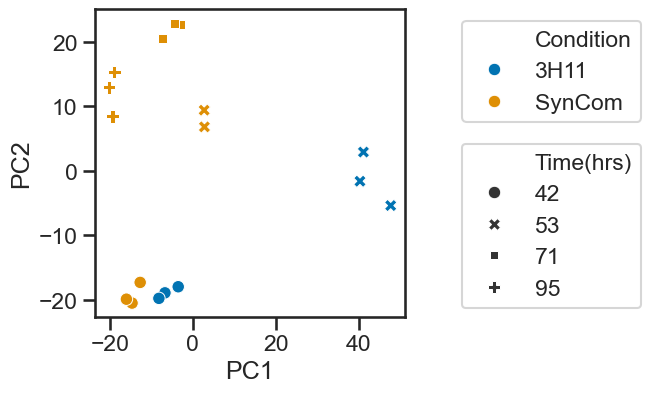

In [102]:
genes=annot_3h11.loc[annot_3h11['KEGG pathway'].dropna().index.values].Query.values
h11=vsd_3h11[(vsd_3h11.index.isin(genes))&(~vsd_3h11.index.isin(nc_genes))].T
h11=h11.drop('SynCom_C_T53_repeat_L1',axis=0)
zvals=h11.apply(zscore)
pca = PCA(n_components=3)
res = pca.fit_transform(h11.dropna(axis=1))
colors=sns.color_palette('colorblind')
colors=[colors[0],colors[1]]
pca_df = pd.DataFrame(data = res, columns = ['PC1', 'PC2','PC3'])
pca_df['sample']=zvals.index.values
pca_df['cond']=[x.split('_')[0] for x in pca_df['sample']]
pca_df['rep']=[x.split('_')[1] for x in pca_df['sample']]
pca_df['time']=[int(x.split('_')[2][1:]) for x in pca_df['sample']]
#pca_df=pca_df.drop([12,13,14,18,19,20],axis=0)
plt.figure(figsize=(4,4))
g=sns.scatterplot(x='PC1',y='PC2',data=pca_df,hue='cond',style='time',palette=colors)
handles, labels = g.get_legend_handles_labels()
g.legend(bbox_to_anchor=(1,1))
#plt.ylim(-25,25)
#plt.xlim(-50,50)
g.legend('',frameon=False)
leg1=g.legend(handles[:3],labels[:3],bbox_to_anchor=(1.8,1))
leg2=g.legend(handles[3:],labels[3:],bbox_to_anchor=(1.8,.6)).get_texts()[0].set_text('Time(hrs)')
g.add_artist(leg1).get_texts()[0].set_text('Condition')
#plt.xlim(-50,25)
#plt.savefig('3H11-SynCom-PCA.png',dpi=500,bbox_inches='tight')

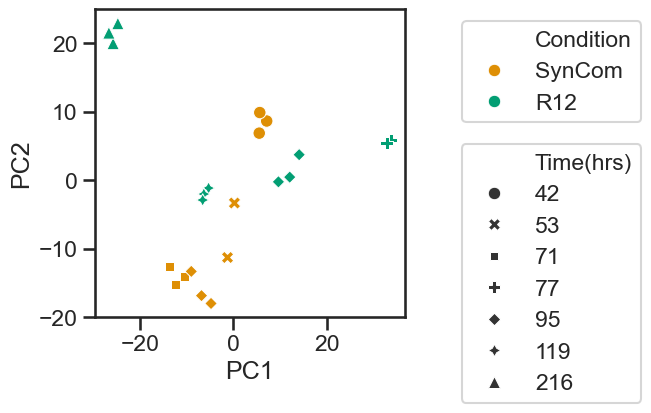

In [103]:
genes=annot_r12.loc[annot_r12['KEGG pathway'].dropna().index.values].Query.values
r12=vsd_r12[(vsd_r12.index.isin(genes))&(~vsd_r12.index.isin(nc_genes))].T
r12=r12.drop('SynCom_C_T53_repeat_L1',axis=0)
zvals=r12.apply(zscore)
pca = PCA(n_components=3)
res = pca.fit_transform(r12.dropna(axis=1))
colors=sns.color_palette('colorblind')
colors=[colors[1],colors[2]]
pca_df = pd.DataFrame(data = res, columns = ['PC1', 'PC2','PC3'])
pca_df['sample']=zvals.index.values
pca_df['cond']=[x.split('_')[0] for x in pca_df['sample']]
pca_df['rep']=[x.split('_')[1] for x in pca_df['sample']]
pca_df['time']=[int(x.split('_')[2][1:]) for x in pca_df['sample']]
#pca_df=pca_df.drop([12,13,14,18,19,20],axis=0)
plt.figure(figsize=(4,4))
g=sns.scatterplot(x='PC1',y='PC2',data=pca_df,hue='cond',style='time',palette=colors)
handles, labels = g.get_legend_handles_labels()
g.legend(bbox_to_anchor=(1,1))
#plt.ylim(-25,25)
#plt.xlim(-50,50)
g.legend('',frameon=False)
leg1=g.legend(handles[:3],labels[:3],bbox_to_anchor=(1.8,1))
leg2=g.legend(handles[3:],labels[3:],bbox_to_anchor=(1.8,.6)).get_texts()[0].set_text('Time(hrs)')
g.add_artist(leg1).get_texts()[0].set_text('Condition')
#plt.xlim(-50,25)
#plt.savefig('3H11-SynCom-PCA.png',dpi=500,bbox_inches='tight')

# Heatmaps and functional enrichment

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/4118794108.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  zvals=zvals.groupby(level=[0,1],axis=1).mean()
/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/4118794108.py:30: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  colors=sns.color_palette('husl',len(pd.unique(paths)))
/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/4118794108.py:31: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  cmap={pd.unique(paths)[i]:colors[i] for i in range(len(pd.unique(paths)))}
/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/4118794108.py:48: FutureWarning: unique with argument that is not not a Series, Index, ExtensionAr

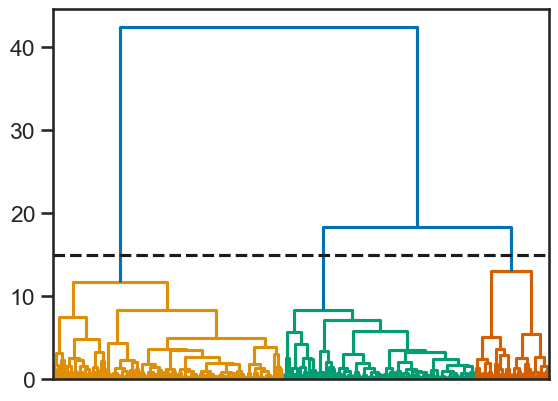

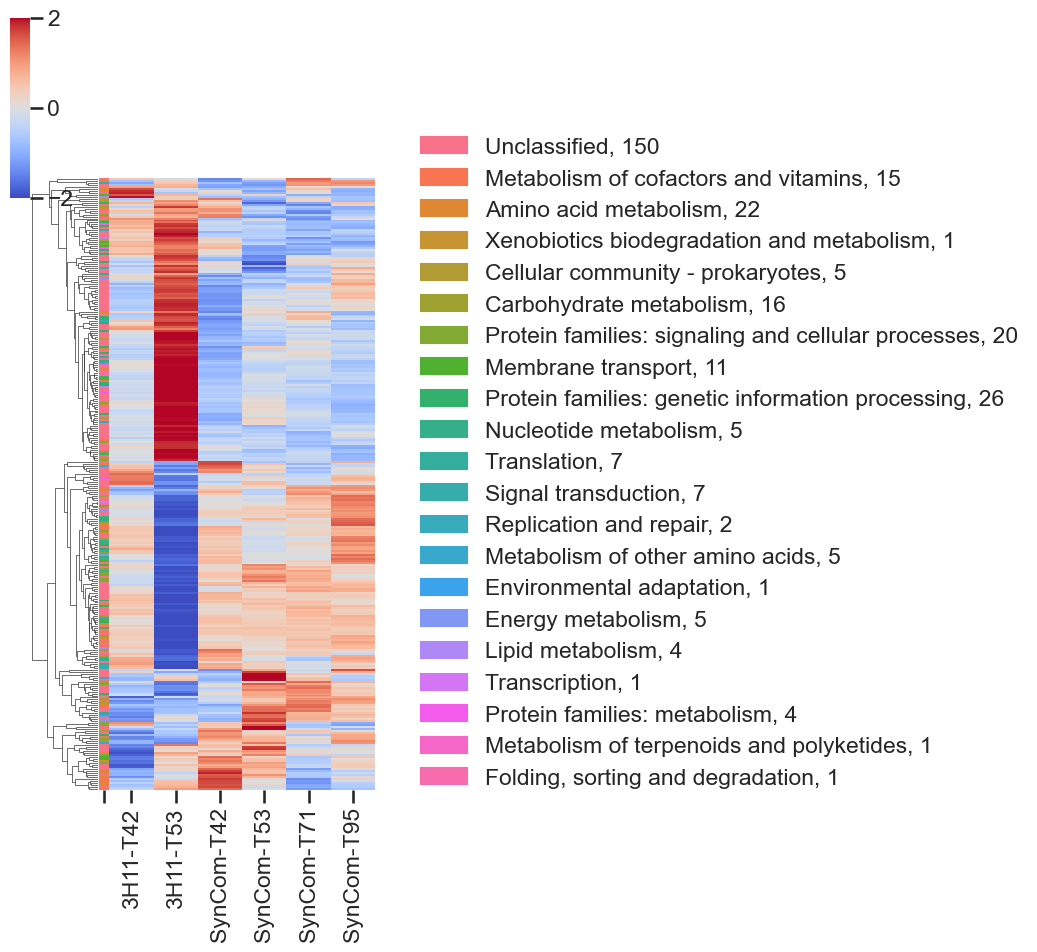

In [104]:
zvals=vsd_3h11.loc[h11_up_hits+h11_down_hits].drop('SynCom_C_T53_repeat_L1',axis=1).apply(zscore,axis=1)
zvals.columns=pd.MultiIndex.from_tuples([(x.split('_')[0],x.split('_')[2]) for x in zvals.columns])
zvals=zvals.groupby(level=[0,1],axis=1).mean()
zvals=zvals.drop_duplicates()
paths=[]
for gene in zvals.index:
    df=annot_3h11[annot_3h11.Query==gene]
    if 'ko' in str(df['KEGG KO']):
        ko=df['KEGG KO'].values[0].split(',')[0][3:]
        path=kegg[kegg['enzyme KO']==ko].pathway.values
        if len(path)==0:
            path='Unclassified'
        else:
            path=path[0]
    else:
        path='Unclassified'
    if 'Unclassified' in path:
        path='Unclassified'
    paths.append(path)
#cmap = {zvals.index[i]:colors[y_pred[i]] for i in range(len(zvals.index))}
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
import matplotlib.patches as mpatches

max_d =15
X=zvals.values
Z = linkage(X, 'ward')
dendro = dendrogram(Z,color_threshold=max_d)
clusters = fcluster(Z, max_d, criterion='distance')
plt.plot(plt.xlim(),(max_d,max_d),'k--')
colors=sns.color_palette('husl',len(pd.unique(paths)))
cmap={pd.unique(paths)[i]:colors[i] for i in range(len(pd.unique(paths)))}
plt.xticks([])
row_colors=pd.Series(paths)
row_colors.index=zvals.index
#row_colors=row_colors[row_colors!='Unclassified']
row_colors=row_colors.map(cmap)

g=sns.clustermap(zvals,cmap='coolwarm',figsize=(4,10),vmin=-2,vmax=2,yticklabels='',row_colors=row_colors,col_cluster=False)
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')
#g.ax_heatmap.set_yticks([])
#g.ax_heatmap.set_xticks([])
#g.ax_heatmap.text(1.5,-3,'R12')
#g.ax_heatmap.plot((0,4),(-3,-3))}
#g.ax_heatmap.text(5.5,-3,'SynCom')
#g.ax_heatmap.text(1,len(idx)*1.05,r'Time $\rightarrow$')
#g.ax_heatmap.text(5.5,len(idx)*1.05,r'Time $\rightarrow$')
handles = [mpatches.Patch(color=cmap[pd.unique(paths)[i]], label=pd.unique(paths)[i]+', %s'%(np.sum(np.array(paths)==pd.unique(paths)[i]))) for i in range(len(pd.unique(paths)))]
g.ax_heatmap.legend(bbox_to_anchor=(3.5,1.1),handles=handles,frameon=False)
#df['clust']=clusters
#plt.savefig('3H11_DEGs_heatmap.pdf',bbox_inches='tight')



Text(365.5555555555556, 0.5, '')

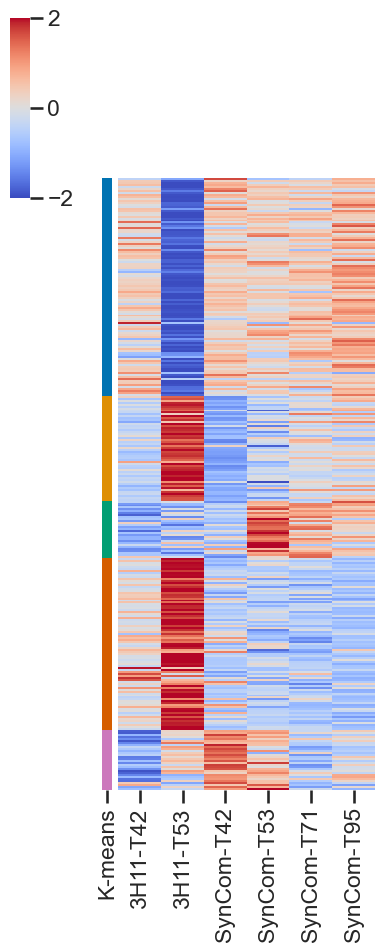

In [105]:
from sklearn.cluster import KMeans
def cluster_genes(df,k=8):
    X = df.values
    km = KMeans(n_clusters=k, random_state=0)
    return km.fit_predict(X)

k=5
y_pred = cluster_genes(zvals,k=k)
colors=sns.color_palette('colorblind')
cmap = {zvals.index[i]:colors[y_pred[i]] for i in range(len(zvals.index))}
handles = [mpatches.Patch(color=colors[i], label='Cluster: %s'%(i+1)) for i in range(k)]
zvals['kmeans'] =y_pred
zvals = zvals.sort_values('kmeans').drop('kmeans',axis=1)

row_colors = pd.Series(zvals.index).map(cmap)
row_colors.index=zvals.index
row_colors.name='K-means'

g=sns.clustermap(zvals,cmap='coolwarm',figsize=(4,10),vmin=-2,vmax=2,yticklabels='',row_colors=row_colors,col_cluster=False,row_cluster=False)
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')
#plt.savefig('3H11_DEGs_heatmap-KMeans.pdf',bbox_inches='tight')

In [106]:
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests

idx = []
for g in annot_3h11.Query:
        ix = list(annot_3h11[annot_3h11['Query'] == g]['KEGG KO'].dropna().values)
        idx+=ix
kos=[]
for ix in idx:
    ix=ix.split('ko:')[1:]
    ix = [i.replace(',','') for i in ix]
    kos+=ix
pop_pathcounts = kegg[kegg['enzyme KO'].isin(kos)].groupby(by='subpathway').count()
k=len(set(y_pred))
clustdf = pd.DataFrame()
pvals = []
total_pathcounts=pd.DataFrame()
path_annot=pd.DataFrame()
for clust in range(1,k+1):
    #For each cluster get the associated genes"
    genes =  zvals.index[y_pred==clust-1]
    #M is the population size 
    #n is the number of successes in the population 
    #N is the sample size 
    #X is the number of drawn “successes”.
    idx = []
    #For each gene figure out what its position(s) is(are) in the annotation table
    ko_dict={}
    kos=[]
    for g in genes:
        ix = list(annot_3h11[annot_3h11['Query'] == g]['KEGG KO'].dropna().values)
        if len(ix)==0:
            continue
            ko_dict[g]=np.nan
        ko_dict[g]=[]
        for i in ix:
            i=i.split('ko:')[1:]
            i = [x.replace(',','') for x in i]
            kos+=i
            ko_dict[g]+=i
    #Count how many times each term shows up in table for the set of genes
    pathcounts = kegg[kegg['enzyme KO'].isin(kos)].groupby(by='subpathway').count()
    pathcounts['cluster']=clust
    total_pathcounts=pd.concat([total_pathcounts,pathcounts])
    annot=kegg[kegg['enzyme KO'].isin(kos)]
    annot['cluster']=clust
    path_annot=pd.concat([path_annot,annot])
    
    #Get sample and population size params
    N=pathcounts.superpathway.sum()
    M=pop_pathcounts.superpathway.sum()
    IDs = []
    smp_count =[]
    null_count =[]
    pvals=[]
    #Loop  through each term and test if it's significantly enriched using the hypergeometric test
    for val in pathcounts.index:
        n =pop_pathcounts.loc[val,'superpathway']
        #Don't test terms with less then 3 representative, could be problematic
        if val in IDs or n <3:
            continue
        IDs.append(val)
        x = pathcounts.loc[val,'superpathway']
        smp_count.append(x)
        null_count.append(n)
        pval = hypergeom.sf(x-1, M, n, N)
        pvals.append(pval)
    #Correct p-values
    smp_count=np.array(smp_count)
    null_count=np.array(null_count)
    IDs = np.array(IDs)
    df = pd.DataFrame(np.array([IDs,pvals,len(pvals)*[clust],smp_count,null_count]).T,columns=['name','pval','clust','clust_n','null_n'])
    #df['logp'] = -np.log(df['pval'].astype(float))
    clustdf = pd.concat([clustdf,df],ignore_index=True)
#Format clustdf values and calculate percentage of genes in each category found in the cluster
clustdf['clust_n']=clustdf['clust_n'].astype(float)
clustdf['null_n']=clustdf['null_n'].astype(float)
clustdf['percent'] = clustdf['clust_n']/clustdf['null_n']

clustdf=clustdf.sort_values(by='pval')
rej, pval_corr = multipletests(clustdf['pval'].values.astype(float), method='fdr_bh',alpha=0.01)[:2]
clustdf['pval']=pval_corr
clustdf=clustdf[clustdf['pval']<=0.05]
#clustdf['logp']=np.log(clustdf['pval'].values)
for clust,df in clustdf.groupby(by='clust'):
    genes =  zvals.index[y_pred==int(clust)-1]
    print('Cluster %s: %s\n'%(int(clust),len(genes)))
    for i in df.index.values:
        print(df.loc[i,'name'],df.loc[i,'pval'],df.loc[i,'clust_n'])
    print('\n--------------------------------------------------------')

Cluster 3: 29

Histidine metabolism 0.02961032376232276 4.0

--------------------------------------------------------


/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/4081635068.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annot['cluster']=clust
/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/4081635068.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annot['cluster']=clust
/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/4081635068.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

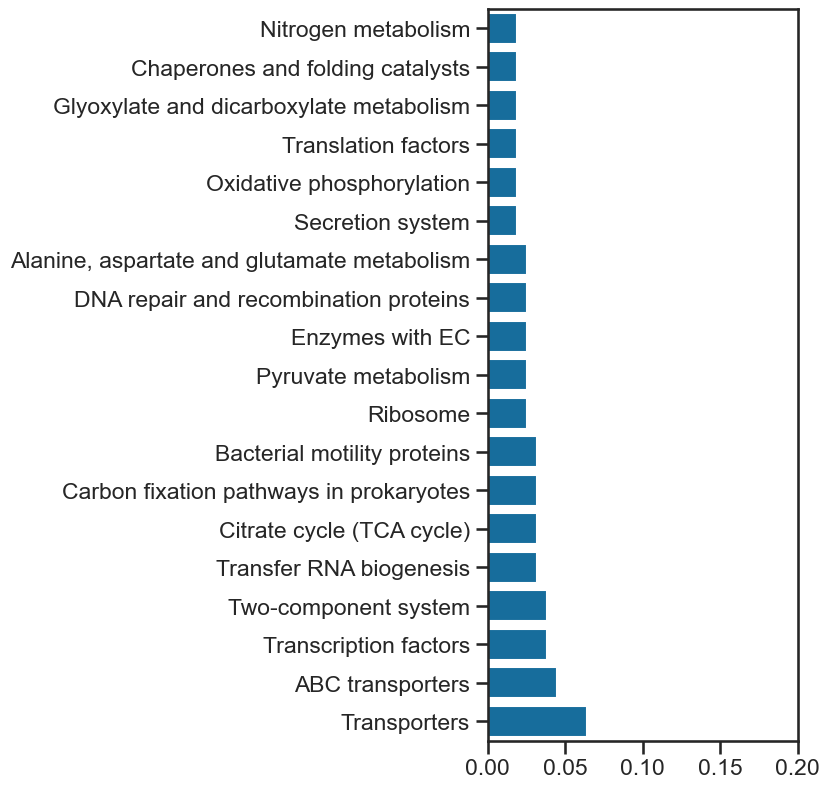

<Figure size 640x480 with 0 Axes>

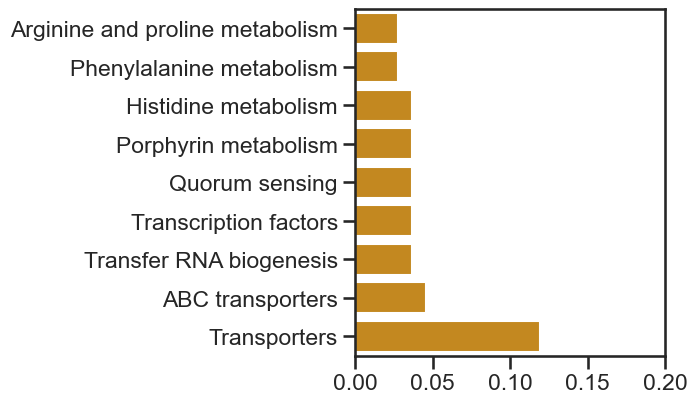

<Figure size 640x480 with 0 Axes>

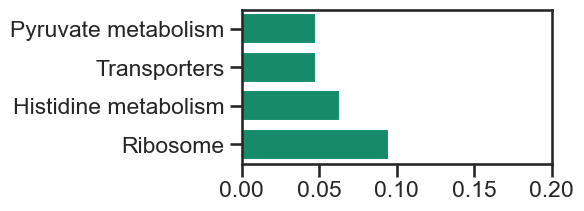

<Figure size 640x480 with 0 Axes>

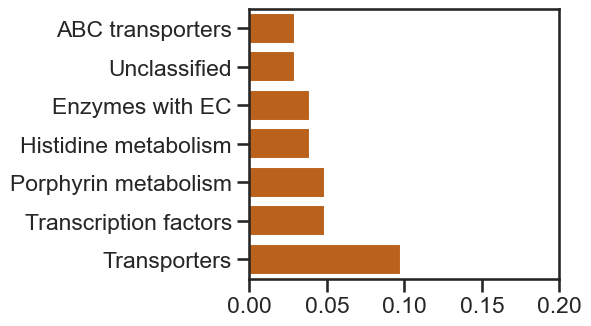

<Figure size 640x480 with 0 Axes>

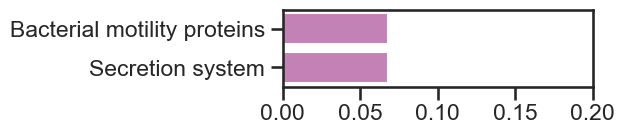

<Figure size 640x480 with 0 Axes>

In [107]:
res=pd.DataFrame()
colors=sns.color_palette('colorblind')
for idx,df in total_pathcounts.groupby(by='cluster'):
    frac=df/df.sum()
    frac=frac[df.pathway>2]
    frac=frac['pathway'].reset_index()
    frac.columns=['pathway','frac']
    frac['cluster']=idx
    res=pd.concat([res,frac],ignore_index=True)
    height=0.5*len(frac)
    plt.figure(figsize=(4,height))
    sns.barplot(y='pathway',x='frac',data=frac.sort_values(by='frac'),color=colors[idx-1])
    plt.xlabel('')
    plt.ylabel('')
    plt.xlim(0,0.2)
    #plt.savefig('3H11-Kmeans-barplot-cluster-%s.pdf'%(idx),bbox_inches='tight')
    plt.show()
    plt.clf()

Text(790.7916666666666, 0.5, '')

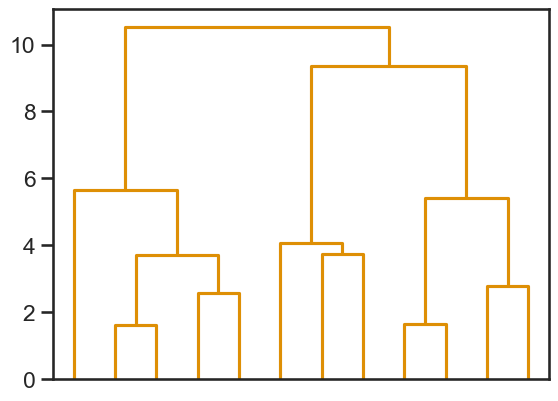

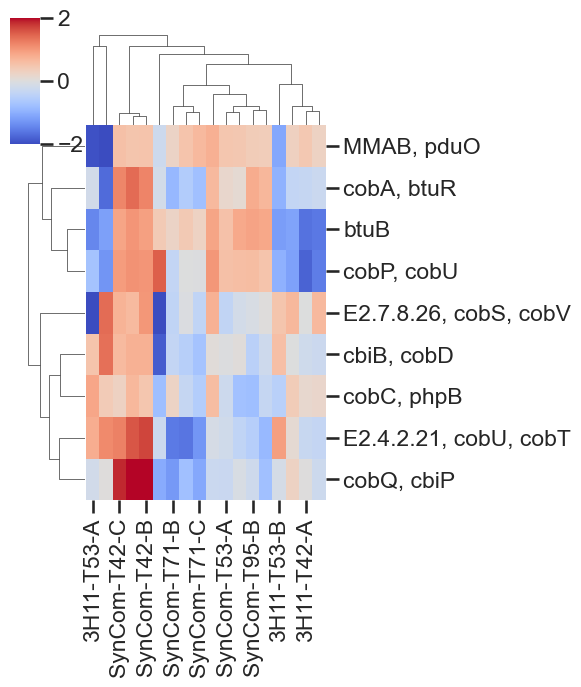

In [195]:
b12_kos_fin=['K00798','K19221','K02232','K02225','K02227','K02231','K00768','K02226','K22316','K02233']
order=['K00798','K19221','K02232','K02227','K02231','K00768','K02226','K02233']

idx=annot_3h11['KEGG KO'].dropna().index
tmp=annot_3h11.loc[idx]

ko_genes={}
genes=[]
for ko in b12_kos_fin:
    for i in tmp.index:
        if ko in tmp.loc[i,'KEGG KO']:
            if ko not in ko_genes:
                ko_genes[ko]=[]
            ko_genes[ko].append(annot_3h11.loc[i].Query)
            genes.append(annot_3h11.loc[i].Query)

x=annot_3h11.Preferred_name.dropna()
idx=x[x.str.contains('btuB')].index
genes+=list(annot_3h11.loc[idx].Query.values)

tmp=vsd_3h11.loc[genes]
tmp.columns=[x.split('_')[0]+'-'+x.split('_')[2]+'-'+x.split('_')[1] for x in tmp.columns]
tmp=tmp.apply(zscore,axis=1)

subpaths=[]
for gene in tmp.index:
    df=annot_3h11[annot_3h11.Query==gene]
    if 'ko' in str(df['KEGG KO']):
        ko=df['KEGG KO'].values[0].split(',')[0][3:]
        path=kegg[kegg['enzyme KO']==ko].enzyme.values[0]
    else:
        path='Unclassified'
    if 'Unclassified' in path:
        path='Unclassified'
    subpaths.append(path.split(';')[0])
max_d =15
X=tmp.values
Z = linkage(X, 'ward')
dendro = dendrogram(Z,color_threshold=max_d)
clusters = fcluster(Z, max_d, criterion='distance')
plt.plot(plt.xlim(),(max_d,max_d),'k--')
colors=sns.color_palette('tab20')
#cmap={pd.unique(paths)[i]:colors[i-1] for i in range(1,len(pd.unique(paths)))}
plt.xticks([])
#row_colors=pd.Series(paths)
#row_colors.index=zvals.index
#row_colors=row_colors.map(cmap)
tmp.index=subpaths
#tmp.index=tmp.index.map(genes_ko)
g=sns.clustermap(tmp.groupby(level=0).mean(),cmap='coolwarm',figsize=(6,7),vmin=-2,vmax=2,yticklabels=1)
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/2308404920.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.violinplot(x='org',y=0,data=df,palette=[colors[0],colors[1]])


TtestResult(statistic=-2.6715965606890624, pvalue=0.008483814362873016, df=134.22546289741288)

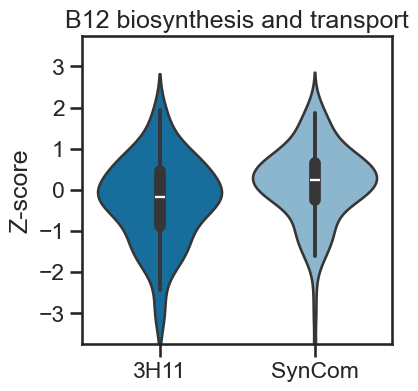

In [196]:
plt.figure(figsize=(4,4))
colors=sns.color_palette('colorblind')
colors=[colors[0]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)

df=tmp.stack().reset_index()
df['time']=[x.split('-')[1] for x in df['level_1']]
df['org']=[x.split('-')[0] for x in df['level_1']]

g=sns.violinplot(x='org',y=0,data=df,palette=[colors[0],colors[1]])
#sns.stripplot(x='org',y=0,data=df, dodge=True,color='k',alpha=0.5)
plt.ylabel('Z-score')
plt.ylim(-2.65,2.65)
#plt.xticks(rotation=90)
plt.xlabel('')
#plt.legend(bbox_to_anchor=(1,1))
plt.title('B12 biosynthesis and transport')
plt.ylim(-3.75,3.75)
plt.yticks([3,2,1,0,-1,-2,-3])
#plt.savefig('3H11-SynCom-B12-violinplot-v2.pdf',bbox_inches='tight')
x1=df[df.org=='3H11'][0].values
x2=df[df.org=='SynCom'][0].values

ttest_ind(x1,x2,equal_var=False)

In [183]:
gallery = pd.read_csv('data/transcriptomics-gallery.csv',index_col=0)
gc = pd.read_csv('data/transcriptomics-GC.csv',index_col=0)
gallery['nitrate(mM)']=gallery['TON (mM)']-gallery['nitrite(mM)']
idx=gallery[gallery['nitrate(mM)']<0].index
gallery.loc[idx,'nitrate(mM)']=0
gallery

,hrs,sample,nitrite,nitrite(mM),TON,TON (mM),condition,rep,nitrate(mM)
0,0,SynCom-4,0.00,0.000000,102030.3,7.287879,SynCom,4,7.287879
1,0,SynCom-5,0.00,0.000000,108555.6,7.753971,SynCom,5,7.753971
2,0,SynCom-6,0.00,0.000000,105627.8,7.544843,SynCom,6,7.544843
3,23,R12-1,1.92,0.000137,103392.3,7.385164,R12,1,7.385027
4,23,R12-2,3.86,0.000276,105089.0,7.506357,R12,2,7.506081
...,...,...,...,...,...,...,...,...,...
76,0,R12-16,0.00,0.000000,108555.6,7.753971,R12,16,7.753971
77,0,R12-17,0.00,0.000000,105627.8,7.544843,R12,17,7.544843
78,0,3H11-1,0.00,0.000000,102030.3,7.287879,3H11,1,7.287879
79,0,3H11-2,0.00,0.000000,108555.6,7.753971,3H11,2,7.753971


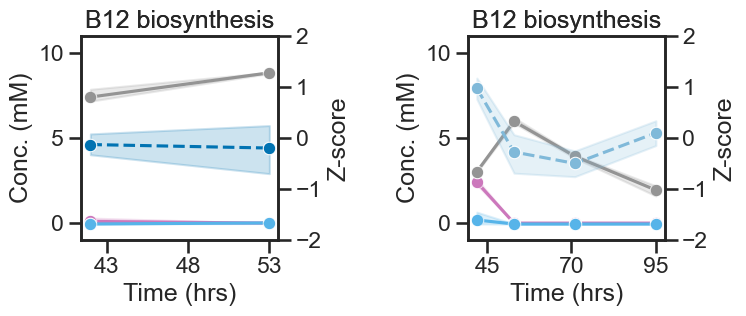

<Figure size 640x480 with 0 Axes>

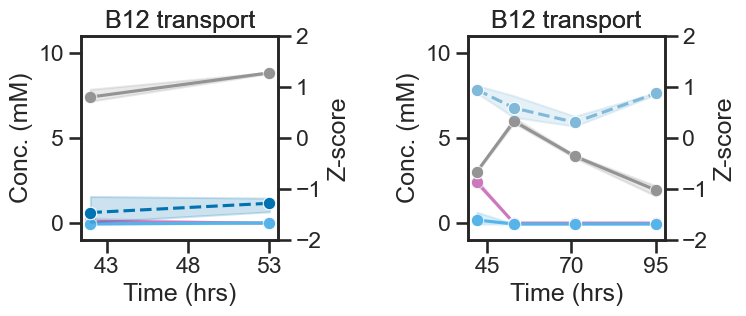

<Figure size 640x480 with 0 Axes>

In [200]:
df=pd.DataFrame(tmp.stack().reset_index())
df['time']=[x.split('-')[1] for x in df['level_1']]
df['org']=[x.split('-')[0] for x in df['level_1']]
df['t']=[int(x[1:]) for x in df['time']]
df.columns=['gene','sample','z-score','timepoint','org','time']
df1=df[df.gene!='btuB']
df2=df[df.gene=='btuB']

colors=sns.color_palette('colorblind')
colors=[colors[0]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)

colors2=sns.color_palette('colorblind')
colors2=[colors2[4],colors2[7],colors2[9]]
xtick_sets=[[43,48,53],[45,70,95]]
names = ['B12 biosynthesis','B12 transport']
k=0
for d in [df1,df2]:
    fig,ax = plt.subplots(1,2,figsize=(8,3.5))
    ax2=[]
    i=0
    for org in ['3H11','SynCom']:
        ax2.append(ax[i].twinx())
        j=0
        for chem in ['nitrate(mM)','nitrite(mM)']:
            sns.lineplot(x='hrs',y=chem,data=gallery[(gallery.condition == org)&(gallery.hrs.isin(d[d.org==org].time))],marker='o',color=colors2[j],ax=ax[i],label=None,zorder=1)
            j+=1
        sns.lineplot(x='hrs',y='nitrous oxide (mM)',data=gc[(gc.condition == org)&(gc.hrs.isin(d[d.org==org].time))],marker='o',color=colors2[j],ax=ax[i],label=None,zorder=1)
        sns.lineplot(x='time',y='z-score',data=d[d.org==org],color=colors[i],marker='o',ax=ax2[i],label=None,linestyle='--')
        ax2[i].set_ylim(-2,2)
        ax2[i].set_title(names[k])
        ax2[i].set_ylabel('Z-score')
        ax2[i].set_xlabel('Time (hrs)')
        ax[i].set_ylabel('Conc. (mM)')
        ax[i].set_ylim(-1,11)
        ax[i].set_title(names[k])
        ax[i].set_xlabel('Time (hrs)')
        ax[i].set_xticks(xtick_sets[i])
        i+=1
       
   
    plt.tight_layout()
    #plt.savefig('SynCom-3H11-%s-lineplot+chems.pdf'%(names[k]),bbox_inches='tight')
    k+=1
    plt.show()
    plt.clf()

In [ ]:
d=df.copy()
d['time']=[x.split('-')[1] for x in d['level_1']]
d['org']=[x.split('-')[0] for x in d['level_1']]
d['t']=[int(x[1:]) for x in d['time']]
d.columns=['sample','gene','z-score','timepoint','org','time']

colors=sns.color_palette('colorblind')
colors=[colors[0]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)

colors2=sns.color_palette('colorblind')
colors2=[colors2[4],colors2[7],colors2[9]]
xtick_sets=[[43,48,53],[45,70,95]]

k=0

fig,ax = plt.subplots(1,2,figsize=(8,3.5))
ax2=[]
i=0
for org in ['3H11','SynCom']:
    ax2.append(ax[i].twinx())
    j=0
    for chem in ['nitrate(mM)','nitrite(mM)']:
        sns.lineplot(x='hrs',y=chem,data=gallery[(gallery.condition == org)&(gallery.hrs.isin(d[d.org==org].time))],marker='o',color=colors2[j],ax=ax[i],label=None,zorder=1)
        j+=1
    sns.lineplot(x='hrs',y='nitrous oxide (mM)',data=gc[(gc.condition == org)&(gc.hrs.isin(d[d.org==org].time))],marker='o',color=colors2[j],ax=ax[i],label=None,zorder=1)
    sns.lineplot(x='time',y='z-score',data=d[d.org==org],color=colors[i],marker='o',ax=ax2[i],label=None,linestyle='--')
    ax2[i].set_ylim(-2,2)
    ax2[i].set_title(cat)
    ax2[i].set_ylabel('Z-score')
    ax2[i].set_xlabel('Time (hrs)')
    ax[i].set_ylabel('Conc. (mM)')
    ax[i].set_ylim(-1,11)
    ax[i].set_xlabel('Time (hrs)')
    ax[i].set_xticks(xtick_sets[i])
    i+=1


plt.tight_layout()
#plt.savefig('SynCom-3H11-%s-lineplot+chems.pdf'%(cat),bbox_inches='tight')
k+=1
plt.show()
plt.clf()

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/705798823.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(x='org',y=0,data=df,palette=[colors[0],colors[1]],order=['R12','SynCom'])


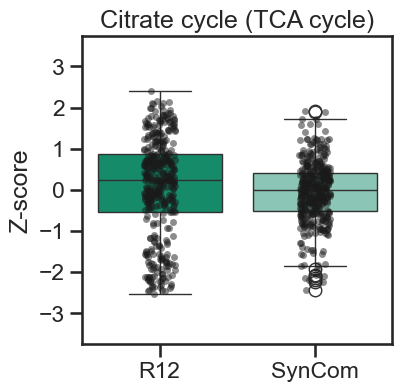

In [187]:
cat='Citrate cycle (TCA cycle)'
kos=kegg[kegg.subpathway==cat]['enzyme KO']


idx=annot_r12['KEGG KO'].dropna().index
tmp=annot_r12.loc[idx]

ko_genes={}
genes=[]
for ko in kos:
    for i in tmp.index:
        if ko in tmp.loc[i,'KEGG KO']:
            if ko not in ko_genes:
                ko_genes[ko]=[]
            ko_genes[ko].append(annot_r12.loc[i].Query)
            genes.append(annot_r12.loc[i].Query)

            
tmp=vsd_r12.loc[genes]
#tmp=tmp[tmp.index.isin(r12_up_hits+r12_down_hits)]
tmp.columns=[x.split('_')[0]+'-'+x.split('_')[2] for x in tmp.columns]
tmp=tmp.apply(zscore,axis=1)


df=pd.DataFrame(tmp.drop_duplicates().unstack().reset_index())
df['time']=[x.split('-')[1] for x in df['level_0']]
df['org']=[x.split('-')[0] for x in df['level_0']]

colors=sns.color_palette('colorblind')
colors=[colors[2]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)
plt.figure(figsize=(4,4))
g=sns.boxplot(x='org',y=0,data=df,palette=[colors[0],colors[1]],order=['R12','SynCom'])
sns.stripplot(x='org',y=0,data=df, dodge=True,color='k',alpha=0.5,order=['R12','SynCom'])
plt.ylabel('Z-score')
plt.xlabel('')
#plt.legend(bbox_to_anchor=(1,1))
plt.title(cat)
plt.ylim(-3.75,3.75)
plt.yticks([3,2,1,0,-1,-2,-3])
plt.savefig('R12-%s.pdf',bbox_inches='tight')
x1=df[df.org=='R12'][0].values
x2=df[df.org=='SynCom'][0].values

#ttest_ind(x1,x2,equal_var=False)

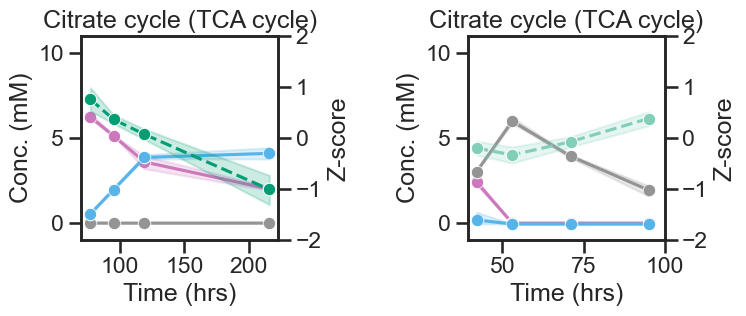

<Figure size 640x480 with 0 Axes>

In [189]:
d=df.copy()
d['time']=[x.split('-')[1] for x in d['level_0']]
d['org']=[x.split('-')[0] for x in d['level_0']]
d['t']=[int(x[1:]) for x in d['time']]
d.columns=['sample','gene','z-score','timepoint','org','time']

colors=sns.color_palette('colorblind')
colors=[colors[2]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)

colors2=sns.color_palette('colorblind')
colors2=[colors2[4],colors2[7],colors2[9]]
xtick_sets=[[100,150,200],[50,75,100]]

k=0

fig,ax = plt.subplots(1,2,figsize=(8,3.5))
ax2=[]
i=0
for org in ['R12','SynCom']:
    ax2.append(ax[i].twinx())
    j=0
    for chem in ['nitrate(mM)','nitrite(mM)']:
        sns.lineplot(x='hrs',y=chem,data=gallery[(gallery.condition == org)&(gallery.hrs.isin(d[d.org==org].time))],marker='o',color=colors2[j],ax=ax[i],label=None,zorder=1)
        j+=1
    sns.lineplot(x='hrs',y='nitrous oxide (mM)',data=gc[(gc.condition == org)&(gc.hrs.isin(d[d.org==org].time))],marker='o',color=colors2[j],ax=ax[i],label=None,zorder=1)
    sns.lineplot(x='time',y='z-score',data=d[d.org==org],color=colors[i],marker='o',ax=ax2[i],label=None,linestyle='--')
    ax2[i].set_ylim(-2,2)
    ax2[i].set_title(cat)
    ax2[i].set_ylabel('Z-score')
    ax2[i].set_xlabel('Time (hrs)')
    ax[i].set_ylabel('Conc. (mM)')
    ax[i].set_ylim(-1,11)
    ax[i].set_xlabel('Time (hrs)')
    ax[i].set_xticks(xtick_sets[i])
    i+=1


plt.tight_layout()
plt.savefig('SynCom-R12-%s-lineplot+chems.pdf'%(cat),bbox_inches='tight')
k+=1
plt.show()
plt.clf()

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/2867266523.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  mean=d.groupby(level=[0,1],axis=1).mean()


Text(796.2916666666666, 0.5, '')

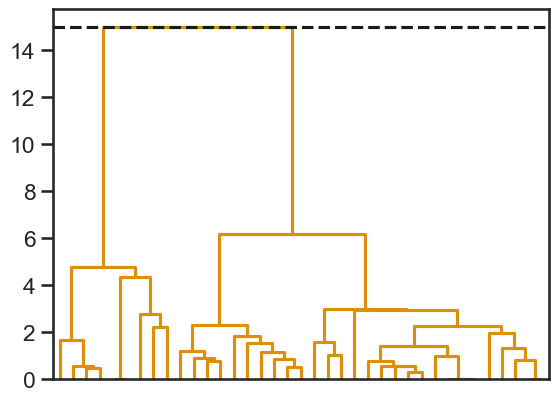

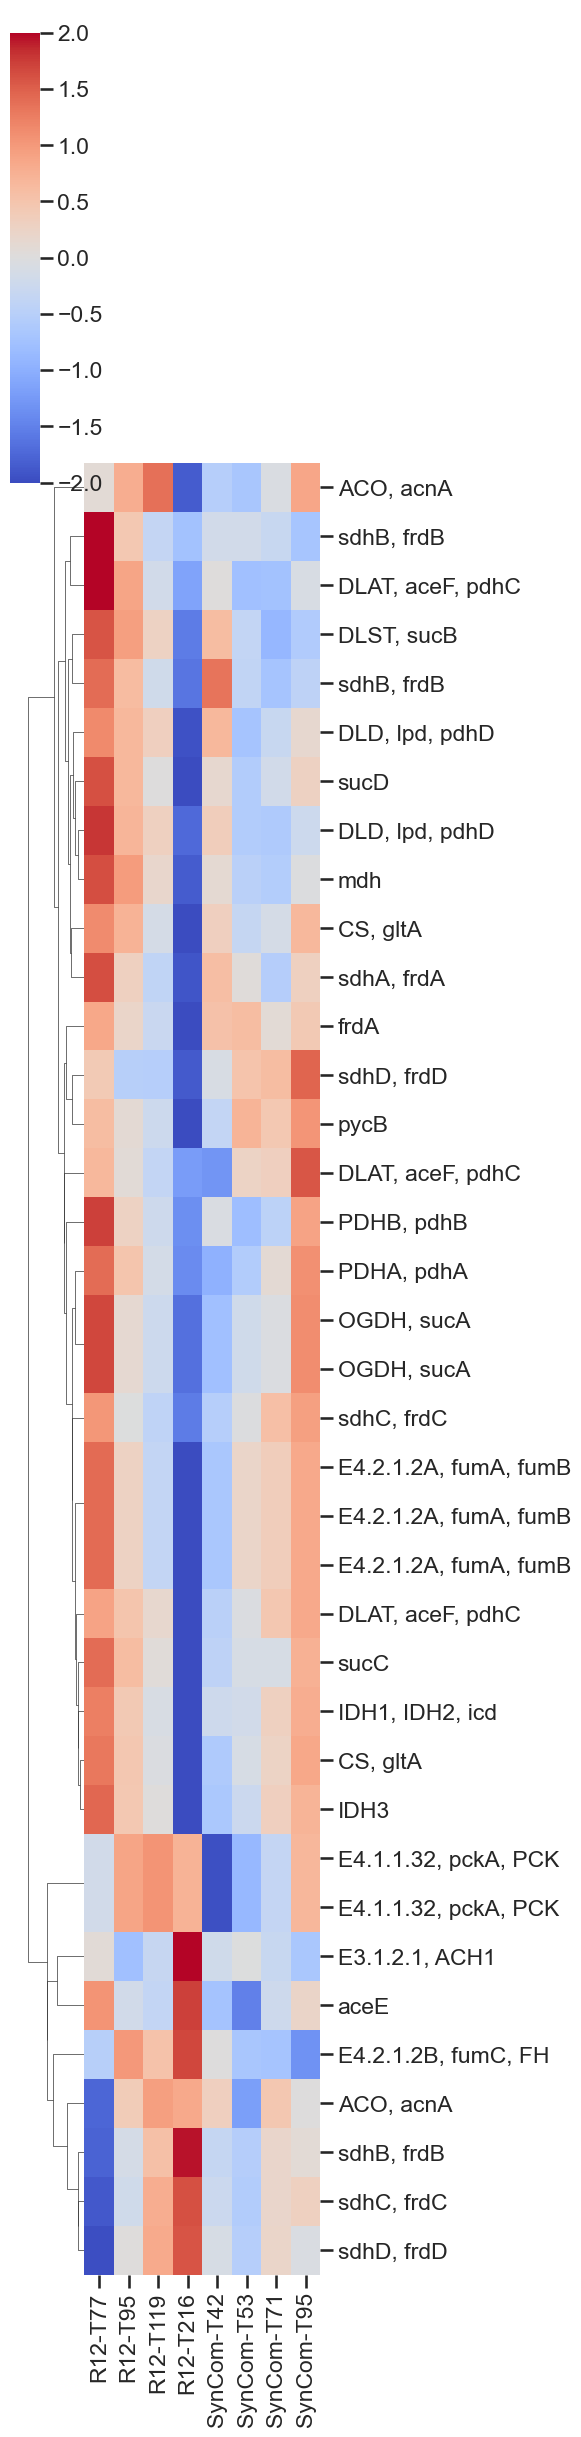

In [140]:
d=tmp.copy()
d.columns=pd.MultiIndex.from_tuples([tuple(x.split('-')) for x in d.columns])
mean=d.groupby(level=[0,1],axis=1).mean()
mean=mean[[(   'R12',  'T77'),
            (   'R12',  'T95'),
            (   'R12', 'T119'),
            (   'R12', 'T216'),
            ('SynCom',  'T42'),
            ('SynCom',  'T53'),
            ('SynCom',  'T71'),
            ('SynCom',  'T95')]]

subpaths=[]
for gene in mean.index:
    df=annot_r12[annot_r12.Query==gene]
    if 'ko' in str(df['KEGG KO']):
        ko=df['KEGG KO'].values[0].split(',')[0][3:]
        if ko in kegg['enzyme KO'].dropna().unique():
            path=kegg[kegg['enzyme KO']==ko].enzyme.values[0]
        else:
            path='Unclassified'       
    else:
        path='Unclassified'
    if 'Unclassified' in path:
        path='Unclassified'
    subpaths.append(path.split(';')[0])
    
    

max_d =15
X=mean.values
Z = linkage(X, 'ward')
dendro = dendrogram(Z,color_threshold=max_d)
clusters = fcluster(Z, max_d, criterion='distance')
plt.plot(plt.xlim(),(max_d,max_d),'k--')
colors=sns.color_palette('tab20')
#cmap={pd.unique(paths)[i]:colors[i-1] for i in range(1,len(pd.unique(paths)))}
plt.xticks([])
#row_colors=pd.Series(paths)
#row_colors.index=zvals.index
#row_colors=row_colors.map(cmap)
mean.index=subpaths
#mean=mean[mean.index.str.contains('leu')]
#tmp.index=tmp.index.map(genes_ko)
g=sns.clustermap(mean,cmap='coolwarm',figsize=(6,25),vmin=-2,vmax=2,yticklabels=1,col_cluster=False)
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')
#plt.savefig('R12-%s-Clustermap.pdf'%cat,bbox_inches='tight')

In [942]:
 ko in kegg['enzyme KO'].dropna().unique()

False

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/1735494888.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.violinplot(x='org',y=0,data=df,palette=[colors[0],colors[1]],order=['R12','SynCom'])


TtestResult(statistic=0.6689099242163785, pvalue=0.5036592612463382, df=1452.143530443457)

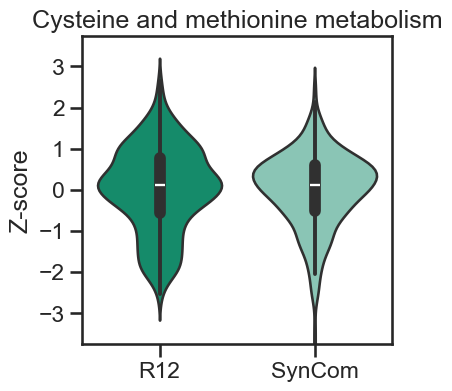

In [141]:
cat='Cysteine and methionine metabolism'
kos=kegg[kegg.subpathway==cat]['enzyme KO']


idx=annot_r12['KEGG KO'].dropna().index
tmp=annot_r12.loc[idx]

ko_genes={}
genes=[]
for ko in kos:
    for i in tmp.index:
        if ko in tmp.loc[i,'KEGG KO']:
            if ko not in ko_genes:
                ko_genes[ko]=[]
            ko_genes[ko].append(annot_r12.loc[i].Query)
            genes.append(annot_r12.loc[i].Query)

            
tmp=vsd_r12.loc[genes]
tmp.columns=[x.split('_')[0]+'-'+x.split('_')[2] for x in tmp.columns]
tmp=tmp.apply(zscore,axis=1)


df=pd.DataFrame(tmp.stack().reset_index())
df['time']=[x.split('-')[1] for x in df['level_1']]
df['org']=[x.split('-')[0] for x in df['level_1']]

colors=sns.color_palette('colorblind')
colors=[colors[2]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)
plt.figure(figsize=(4,4))
g=sns.violinplot(x='org',y=0,data=df,palette=[colors[0],colors[1]],order=['R12','SynCom'])
#sns.stripplot(x='org',y=0,data=df, dodge=True,color='k',alpha=0.5,order=['R12','SynCom'])
plt.ylabel('Z-score')
plt.xlabel('')
#plt.legend(bbox_to_anchor=(1,1))
plt.title(cat)
plt.ylim(-3.75,3.75)
plt.yticks([3,2,1,0,-1,-2,-3])
#plt.savefig('R12-BCAA-violinplot-v2.pdf',bbox_inches='tight')
x1=df[df.org=='R12'][0].values
x2=df[df.org=='SynCom'][0].values

ttest_ind(x1,x2,equal_var=False)

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/3472062034.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  res=annot_r12[annot_3h11['EC number'].str.contains(e).fillna(False)].Query.values
/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/3472062034.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res=annot_r12[annot_3h11['EC number'].str.contains(e).fillna(False)].Query.values
/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/3472062034.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_dow

TtestResult(statistic=-2.2743637205668423, pvalue=0.02407359335427128, df=187.9965554221031)

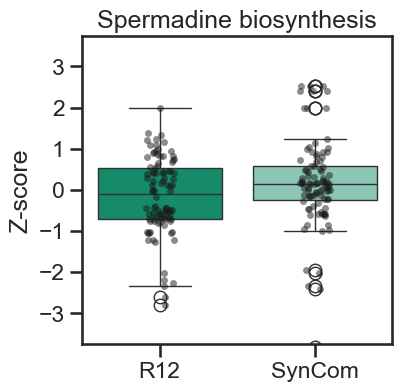

In [142]:
cat='Spermadine biosynthesis'
ec=['3.5.1.38','1.4.1.3','2.3.1.1','2.7.2.8','1.2.1.38','2.6.1.11','2.3.1.35','2.1.3.3','6.3.4.5','4.3.2.1','3.5.3.1','4.1.1.17','4.1.1.50','2.5.1.16','4.1.1.19','2.5.1.22','2.5.1.104','3.5.3.24']
genes=[]
for e in ec:
    res=annot_r12[annot_3h11['EC number'].str.contains(e).fillna(False)].Query.values
    if len(res) >0:
        genes+=list(res)
        
tmp=vsd_r12.loc[genes]
tmp.columns=[x.split('_')[0]+'-'+x.split('_')[2] for x in tmp.columns]
tmp=tmp.apply(zscore,axis=1)
tmp=tmp[tmp.index.isin(r12_up_hits+r12_down_hits)]

df=pd.DataFrame(tmp.stack().reset_index())
df['time']=[x.split('-')[1] for x in df['level_1']]
df['org']=[x.split('-')[0] for x in df['level_1']]

colors=sns.color_palette('colorblind')
colors=[colors[2]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)
plt.figure(figsize=(4,4))
g=sns.boxplot(x='org',y=0,data=df,palette=[colors[0],colors[1]],order=['R12','SynCom'])
sns.stripplot(x='org',y=0,data=df, dodge=True,color='k',alpha=0.5,order=['R12','SynCom'])
plt.ylabel('Z-score')
plt.xlabel('')
#plt.legend(bbox_to_anchor=(1,1))
plt.title(cat)
plt.ylim(-3.75,3.75)
plt.yticks([3,2,1,0,-1,-2,-3])
#plt.savefig('3H11-BCAA-violinplot-v2.pdf',bbox_inches='tight')
x1=df[df.org=='R12'][0].values
x2=df[df.org=='SynCom'][0].values

ttest_ind(x1,x2,equal_var=False)

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/3375822182.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(x='org',y=0,data=df,palette=[colors[0],colors[1]],order=['3H11','SynCom'])


TtestResult(statistic=-2.3180550504803556, pvalue=0.02281620289764349, df=86.14733228986242)

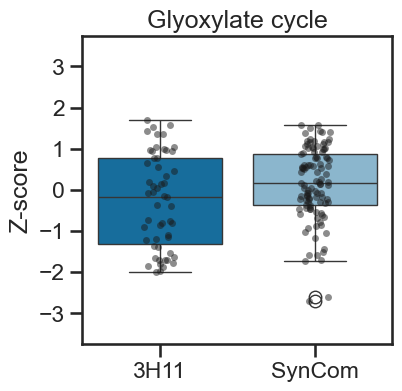

In [143]:
cat= 'Glyoxylate cycle'
kos=['K01647','K01681','K01682','K01637', 'K01638','K19282','K00026','K00025','K00024']


idx=annot_3h11['KEGG KO'].dropna().index
tmp=annot_3h11.loc[idx]

ko_genes={}
genes=[]
for ko in kos:
    for i in tmp.index:
        if ko in tmp.loc[i,'KEGG KO']:
            if ko not in ko_genes:
                ko_genes[ko]=[]
            ko_genes[ko].append(annot_3h11.loc[i].Query)
            genes.append(annot_3h11.loc[i].Query)

#cat='Leucine efflux'
#genes=['GW101-3H11_contig_1_3005']            
tmp=vsd_3h11.loc[genes]
tmp.columns=[x.split('_')[0]+'-'+x.split('_')[2] for x in tmp.columns]
tmp=tmp.apply(zscore,axis=1)
#tmp=tmp[tmp.index.isin(h11_up_hits+h11_down_hits)]

df=pd.DataFrame(tmp.stack().reset_index())
df['time']=[x.split('-')[1] for x in df['level_1']]
df['org']=[x.split('-')[0] for x in df['level_1']]

colors=sns.color_palette('colorblind')
colors=[colors[0]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)
plt.figure(figsize=(4,4))
g=sns.boxplot(x='org',y=0,data=df,palette=[colors[0],colors[1]],order=['3H11','SynCom'])
sns.stripplot(x='org',y=0,data=df, dodge=True,color='k',alpha=0.5,order=['3H11','SynCom'])
plt.ylabel('Z-score')
plt.xlabel('')
#plt.legend(bbox_to_anchor=(1,1))
plt.title(cat)
plt.ylim(-3.75,3.75)
plt.yticks([3,2,1,0,-1,-2,-3])
#plt.savefig('3H11-BCAA-violinplot-v2.pdf',bbox_inches='tight')
x1=df[df.org=='3H11'][0].values
x2=df[df.org=='SynCom'][0].values

ttest_ind(x1,x2,equal_var=False)

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/2557256864.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(x='org',y=0,data=df,palette=[colors[0],colors[1]],order=['3H11','SynCom'])


TtestResult(statistic=-3.9408207817961567, pvalue=0.0001602322089383425, df=89.96399915620964)

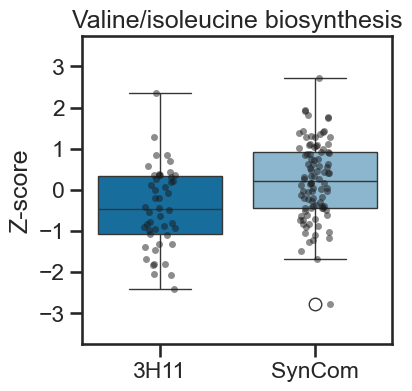

In [144]:

cat= 'Valine/isoleucine biosynthesis'
kos=['K01652','K01653','K11258', 'K00053', 'K01687' ,'K00826']


idx=annot_3h11['KEGG KO'].dropna().index
tmp=annot_3h11.loc[idx]

ko_genes={}
genes=[]
for ko in kos:
    for i in tmp.index:
        if ko in tmp.loc[i,'KEGG KO']:
            if ko not in ko_genes:
                ko_genes[ko]=[]
            ko_genes[ko].append(annot_3h11.loc[i].Query)
            genes.append(annot_3h11.loc[i].Query)

#cat='Leucine efflux'
#genes=['GW101-3H11_contig_1_3005']            
tmp=vsd_3h11.loc[genes]
tmp.columns=[x.split('_')[0]+'-'+x.split('_')[2] for x in tmp.columns]
tmp=tmp.apply(zscore,axis=1)
#tmp=tmp[tmp.index.isin(h11_up_hits+h11_down_hits)]

df=pd.DataFrame(tmp.stack().reset_index())
df['time']=[x.split('-')[1] for x in df['level_1']]
df['org']=[x.split('-')[0] for x in df['level_1']]

colors=sns.color_palette('colorblind')
colors=[colors[0]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)
plt.figure(figsize=(4,4))
g=sns.boxplot(x='org',y=0,data=df,palette=[colors[0],colors[1]],order=['3H11','SynCom'])
sns.stripplot(x='org',y=0,data=df, dodge=True,color='k',alpha=0.5,order=['3H11','SynCom'])
plt.ylabel('Z-score')
plt.xlabel('')
#plt.legend(bbox_to_anchor=(1,1))
plt.title(cat)
plt.ylim(-3.75,3.75)
plt.yticks([3,2,1,0,-1,-2,-3])
#plt.savefig('3H11-BCAA-violinplot-v2.pdf',bbox_inches='tight')
x1=df[df.org=='3H11'][0].values
x2=df[df.org=='SynCom'][0].values

ttest_ind(x1,x2,equal_var=False)

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/2617233658.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(x='org',y=0,data=df,palette=[colors[0],colors[1]],order=['3H11','SynCom'])


TtestResult(statistic=-4.692537424944792, pvalue=2.7159004598628185e-05, df=43.322902523607844)

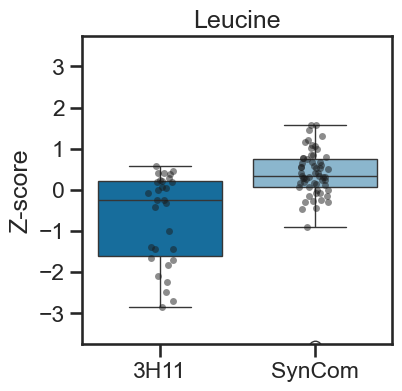

In [145]:


cat= 'Leucine'
kos=['K01649','K01702','K01703','K01704','K00052']


idx=annot_3h11['KEGG KO'].dropna().index
tmp=annot_3h11.loc[idx]

ko_genes={}
genes=[]
for ko in kos:
    for i in tmp.index:
        if ko in tmp.loc[i,'KEGG KO']:
            if ko not in ko_genes:
                ko_genes[ko]=[]
            ko_genes[ko].append(annot_3h11.loc[i].Query)
            genes.append(annot_3h11.loc[i].Query)

#cat='Leucine efflux'
#genes=['GW101-3H11_contig_1_3005']            
tmp=vsd_3h11.loc[genes]
tmp.columns=[x.split('_')[0]+'-'+x.split('_')[2] for x in tmp.columns]
tmp=tmp.apply(zscore,axis=1)
#tmp=tmp[tmp.index.isin(h11_up_hits+h11_down_hits)]

df=pd.DataFrame(tmp.stack().reset_index())
df['time']=[x.split('-')[1] for x in df['level_1']]
df['org']=[x.split('-')[0] for x in df['level_1']]

colors=sns.color_palette('colorblind')
colors=[colors[0]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)
plt.figure(figsize=(4,4))
g=sns.boxplot(x='org',y=0,data=df,palette=[colors[0],colors[1]],order=['3H11','SynCom'])
sns.stripplot(x='org',y=0,data=df, dodge=True,color='k',alpha=0.5,order=['3H11','SynCom'])
plt.ylabel('Z-score')
plt.xlabel('')
#plt.legend(bbox_to_anchor=(1,1))
plt.title(cat)
plt.ylim(-3.75,3.75)
plt.yticks([3,2,1,0,-1,-2,-3])
#plt.savefig('3H11-BCAA-violinplot-v2.pdf',bbox_inches='tight')
x1=df[df.org=='3H11'][0].values
x2=df[df.org=='SynCom'][0].values

ttest_ind(x1,x2,equal_var=False)

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/115600180.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(x='org',y=0,data=df,palette=[colors[0],colors[1]],order=['3H11','SynCom'])


TtestResult(statistic=-1.4528593880050398, pvalue=0.1973536082532695, df=5.892564504346475)

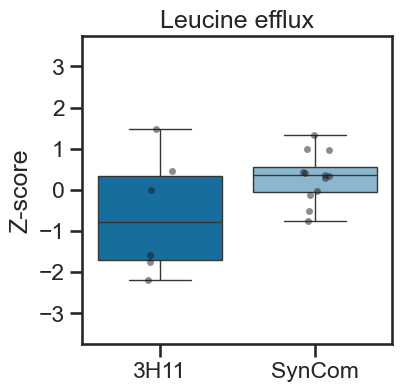

In [184]:
cat='Leucine efflux'
genes=['GW101-3H11_contig_1_3005'] 

tmp=vsd_3h11.loc[genes]
tmp.columns=[x.split('_')[0]+'-'+x.split('_')[2] for x in tmp.columns]
tmp=tmp.apply(zscore,axis=1)
#tmp=tmp[tmp.index.isin(h11_up_hits+h11_down_hits)]

df=pd.DataFrame(tmp.stack().reset_index())
df['time']=[x.split('-')[1] for x in df['level_1']]
df['org']=[x.split('-')[0] for x in df['level_1']]

colors=sns.color_palette('colorblind')
colors=[colors[0]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)
plt.figure(figsize=(4,4))
g=sns.boxplot(x='org',y=0,data=df,palette=[colors[0],colors[1]],order=['3H11','SynCom'])
sns.stripplot(x='org',y=0,data=df, dodge=True,color='k',alpha=0.5,order=['3H11','SynCom'])
plt.ylabel('Z-score')
plt.xlabel('')
#plt.legend(bbox_to_anchor=(1,1))
plt.title(cat)
plt.ylim(-3.75,3.75)
plt.yticks([3,2,1,0,-1,-2,-3])
#plt.savefig('3H11-BCAA-violinplot-v2.pdf',bbox_inches='tight')
x1=df[df.org=='3H11'][0].values
x2=df[df.org=='SynCom'][0].values

ttest_ind(x1,x2,equal_var=False)

In [147]:
b12_genes={}
genes=[]
for g in ['hemB','hemC','hemD','cobA','cobI','cobG','cobJ','cobM','cobF','cobK','cobL','cobH','cobB','cobN','cobS','cobT','cobO','btuR','cobQ','cobD','cobP','cobV','cobU','cobS','cobC','cbiL','cbiH','cbiG','cbiF','cbiD','cbiJ','cbiE','cbiT','cbiC','cbiA','cbiP','cbiB','cbiK','cbiX']:
    kos=kegg[kegg.enzyme.str.contains(g)]['enzyme KO'].values
    b12_genes[g]=[]
    for k in kos:
        idx=annot_3h11['KEGG KO'].dropna()[annot_3h11['KEGG KO'].dropna().str.contains(k)].index
        gene=annot_3h11.loc[idx,'Query']
        if len(gene)>0:
            print(g+':'+str(len(gene)),list(gene))
        b12_genes[g]+=list(gene)
        genes+=list(gene)
b12_genes

hemB:1 ['GW101-3H11_contig_1_410']
hemB:1 ['GW101-3H11_contig_1_410']
hemC:2 ['GW101-3H11_contig_1_1547', 'GW101-3H11_contig_1_1548']
hemD:1 ['GW101-3H11_contig_1_1547']
hemD:3 ['GW101-3H11_contig_1_1547', 'GW101-3H11_contig_1_1548', 'GW101-3H11_contig_1_1668']
hemD:2 ['GW101-3H11_contig_1_1546', 'GW101-3H11_contig_1_1547']
cobA:3 ['GW101-3H11_contig_1_1547', 'GW101-3H11_contig_1_1548', 'GW101-3H11_contig_1_1668']
cobA:1 ['GW101-3H11_contig_1_1668']
cobA:2 ['GW101-3H11_contig_1_3263', 'GW101-3H11_contig_1_3875']
cobB:1 ['GW101-3H11_contig_1_3271']
cobN:1 ['GW101-3H11_contig_1_3264']
cobS:1 ['GW101-3H11_contig_1_957']
cobT:1 ['GW101-3H11_contig_1_3257']
btuR:2 ['GW101-3H11_contig_1_3263', 'GW101-3H11_contig_1_3875']
cobQ:1 ['GW101-3H11_contig_1_3258']
cobD:2 ['GW101-3H11_contig_1_3262', 'GW101-3H11_contig_1_3843']
cobD:1 ['GW101-3H11_contig_1_3261']
cobP:1 ['GW101-3H11_contig_1_3270']
cobV:1 ['GW101-3H11_contig_1_957']
cobU:1 ['GW101-3H11_contig_1_3270']
cobU:1 ['GW101-3H11_contig_1_325

{'hemB': ['GW101-3H11_contig_1_410', 'GW101-3H11_contig_1_410'],
 'hemC': ['GW101-3H11_contig_1_1547', 'GW101-3H11_contig_1_1548'],
 'hemD': ['GW101-3H11_contig_1_1547',
  'GW101-3H11_contig_1_1547',
  'GW101-3H11_contig_1_1548',
  'GW101-3H11_contig_1_1668',
  'GW101-3H11_contig_1_1546',
  'GW101-3H11_contig_1_1547'],
 'cobA': ['GW101-3H11_contig_1_1547',
  'GW101-3H11_contig_1_1548',
  'GW101-3H11_contig_1_1668',
  'GW101-3H11_contig_1_1668',
  'GW101-3H11_contig_1_3263',
  'GW101-3H11_contig_1_3875'],
 'cobI': [],
 'cobG': [],
 'cobJ': [],
 'cobM': [],
 'cobF': [],
 'cobK': [],
 'cobL': [],
 'cobH': [],
 'cobB': ['GW101-3H11_contig_1_3271'],
 'cobN': ['GW101-3H11_contig_1_3264'],
 'cobS': ['GW101-3H11_contig_1_957'],
 'cobT': ['GW101-3H11_contig_1_3257'],
 'cobO': [],
 'btuR': ['GW101-3H11_contig_1_3263', 'GW101-3H11_contig_1_3875'],
 'cobQ': ['GW101-3H11_contig_1_3258'],
 'cobD': ['GW101-3H11_contig_1_3262',
  'GW101-3H11_contig_1_3843',
  'GW101-3H11_contig_1_3261'],
 'cobP': ['GW

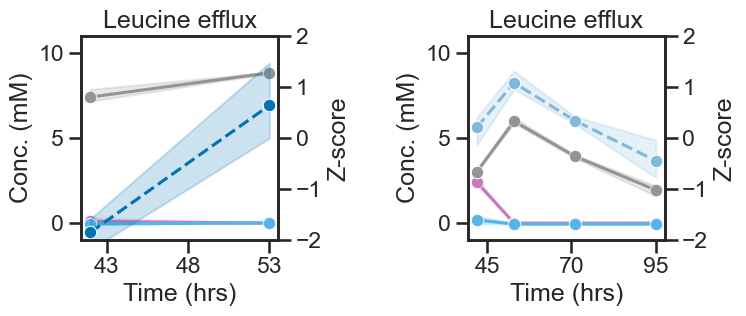

<Figure size 640x480 with 0 Axes>

In [186]:
d=df.copy()
d['time']=[x.split('-')[1] for x in d['level_1']]
d['org']=[x.split('-')[0] for x in d['level_1']]
d['t']=[int(x[1:]) for x in d['time']]
d.columns=['sample','gene','z-score','timepoint','org','time']

colors=sns.color_palette('colorblind')
colors=[colors[0]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)

colors2=sns.color_palette('colorblind')
colors2=[colors2[4],colors2[7],colors2[9]]
xtick_sets=[[43,48,53],[45,70,95]]

k=0

fig,ax = plt.subplots(1,2,figsize=(8,3.5))
ax2=[]
i=0
for org in ['3H11','SynCom']:
    ax2.append(ax[i].twinx())
    j=0
    for chem in ['nitrate(mM)','nitrite(mM)']:
        sns.lineplot(x='hrs',y=chem,data=gallery[(gallery.condition == org)&(gallery.hrs.isin(d[d.org==org].time))],marker='o',color=colors2[j],ax=ax[i],label=None,zorder=1)
        j+=1
    sns.lineplot(x='hrs',y='nitrous oxide (mM)',data=gc[(gc.condition == org)&(gc.hrs.isin(d[d.org==org].time))],marker='o',color=colors2[j],ax=ax[i],label=None,zorder=1)
    sns.lineplot(x='time',y='z-score',data=d[d.org==org],color=colors[i],marker='o',ax=ax2[i],label=None,linestyle='--')
    ax2[i].set_ylim(-2,2)
    ax2[i].set_title(cat)
    ax2[i].set_ylabel('Z-score')
    ax2[i].set_xlabel('Time (hrs)')
    ax[i].set_ylabel('Conc. (mM)')
    ax[i].set_ylim(-1,11)
    ax[i].set_xlabel('Time (hrs)')
    ax[i].set_xticks(xtick_sets[i])
    i+=1


plt.tight_layout()
#plt.savefig('SynCom-3H11-%s-lineplot+chems.pdf'%(cat),bbox_inches='tight')
k+=1
plt.show()
plt.clf()

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/1623939895.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(x='org',y=0,data=df,palette=[colors[0],colors[1]],order=['3H11','SynCom'])


TtestResult(statistic=-2.386134327930602, pvalue=0.031504699517168624, df=14.173445429571055)

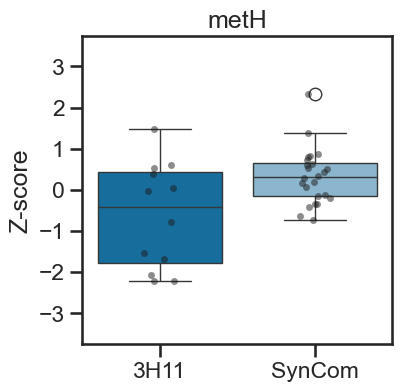

In [148]:
#MetH
from scipy.stats import ttest_ind
cat='metH'
genes=annot_3h11[annot_3h11['Preferred_name']=='metH'].Query.values
tmp=vsd_3h11.loc[genes]
tmp.columns=[x.split('_')[0]+'-'+x.split('_')[2] for x in tmp.columns]
tmp=tmp.apply(zscore,axis=1)
#tmp=tmp[tmp.index.isin(h11_up_hits+h11_down_hits)]

df=pd.DataFrame(tmp.stack().reset_index())
df['time']=[x.split('-')[1] for x in df['level_1']]
df['org']=[x.split('-')[0] for x in df['level_1']]

colors=sns.color_palette('colorblind')
colors=[colors[0]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)
plt.figure(figsize=(4,4))
g=sns.boxplot(x='org',y=0,data=df,palette=[colors[0],colors[1]],order=['3H11','SynCom'])
sns.stripplot(x='org',y=0,data=df, dodge=True,color='k',alpha=0.5,order=['3H11','SynCom'])
plt.ylabel('Z-score')
plt.xlabel('')
#plt.legend(bbox_to_anchor=(1,1))
plt.title(cat)
plt.ylim(-3.75,3.75)
plt.yticks([3,2,1,0,-1,-2,-3])
#plt.savefig('3H11-BCAA-violinplot-v2.pdf',bbox_inches='tight')
x1=df[df.org=='3H11'][0].values
x2=df[df.org=='SynCom'][0].values

ttest_ind(x1,x2,equal_var=False)

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/1455757041.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(x='org',y=0,data=df,palette=[colors[0],colors[1]],order=['R12','SynCom'])


TtestResult(statistic=0.2207466486266658, pvalue=0.8262665909966962, df=46.0)

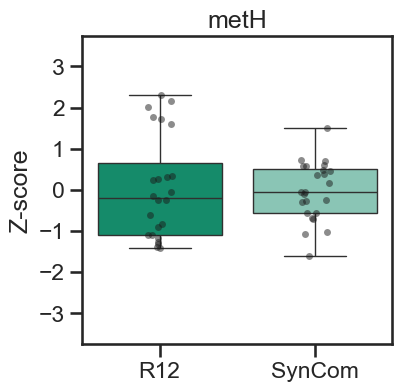

In [149]:
#MetH
from scipy.stats import ttest_ind
cat='metH'
genes=annot_r12[annot_r12['Preferred_name']=='metH'].Query.values
tmp=vsd_r12.loc[genes]
tmp.columns=[x.split('_')[0]+'-'+x.split('_')[2] for x in tmp.columns]
tmp=tmp.apply(zscore,axis=1)
#tmp=tmp[tmp.index.isin(h11_up_hits+h11_down_hits)]

df=pd.DataFrame(tmp.stack().reset_index())
df['time']=[x.split('-')[1] for x in df['level_1']]
df['org']=[x.split('-')[0] for x in df['level_1']]

colors=sns.color_palette('colorblind')
colors=[colors[2]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)
plt.figure(figsize=(4,4))
g=sns.boxplot(x='org',y=0,data=df,palette=[colors[0],colors[1]],order=['R12','SynCom'])
sns.stripplot(x='org',y=0,data=df, dodge=True,color='k',alpha=0.5,order=['R12','SynCom'])
plt.ylabel('Z-score')
plt.xlabel('')
#plt.legend(bbox_to_anchor=(1,1))
plt.title(cat)
plt.ylim(-3.75,3.75)
plt.yticks([3,2,1,0,-1,-2,-3])
#plt.savefig('3H11-BCAA-violinplot-v2.pdf',bbox_inches='tight')
x1=df[df.org=='R12'][0].values
x2=df[df.org=='SynCom'][0].values
ttest_ind(x1,x2)

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/2348386887.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(x='org',y=0,data=df,palette=[colors[0],colors[1]],order=['R12','SynCom'])


TtestResult(statistic=-1.040554488545078, pvalue=0.3093834971512547, df=22.0)

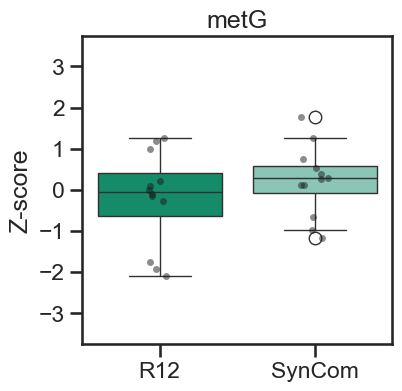

In [150]:
#MetH
from scipy.stats import ttest_ind
cat='metG'
genes=annot_r12[annot_r12['Preferred_name']=='metG'].Query.values
tmp=vsd_r12.loc[genes]
tmp.columns=[x.split('_')[0]+'-'+x.split('_')[2] for x in tmp.columns]
tmp=tmp.apply(zscore,axis=1)
#tmp=tmp[tmp.index.isin(h11_up_hits+h11_down_hits)]

df=pd.DataFrame(tmp.stack().reset_index())
df['time']=[x.split('-')[1] for x in df['level_1']]
df['org']=[x.split('-')[0] for x in df['level_1']]

colors=sns.color_palette('colorblind')
colors=[colors[2]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)
plt.figure(figsize=(4,4))
g=sns.boxplot(x='org',y=0,data=df,palette=[colors[0],colors[1]],order=['R12','SynCom'])
sns.stripplot(x='org',y=0,data=df, dodge=True,color='k',alpha=0.5,order=['R12','SynCom'])
plt.ylabel('Z-score')
plt.xlabel('')
#plt.legend(bbox_to_anchor=(1,1))
plt.title(cat)
plt.ylim(-3.75,3.75)
plt.yticks([3,2,1,0,-1,-2,-3])
#plt.savefig('3H11-BCAA-violinplot-v2.pdf',bbox_inches='tight')
x1=df[df.org=='R12'][0].values
x2=df[df.org=='SynCom'][0].values
ttest_ind(x1,x2)

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/2376717821.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(x='org',y=0,data=df,palette=[colors[0],colors[1]])


([<matplotlib.axis.YTick at 0x32f4c7980>,
 [Text(0, 3, '3'),
  Text(0, 2, '2'),
  Text(0, 1, '1'),
  Text(0, 0, '0'),
  Text(0, -1, '−1'),
  Text(0, -2, '−2'),
  Text(0, -3, '−3')])

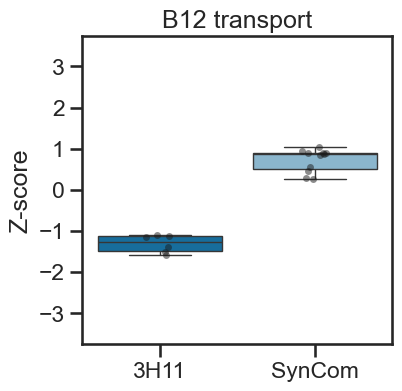

In [152]:
#B12 transport
x=annot_3h11.Preferred_name.dropna()
idx=x[x.str.contains('btuB')].index
genes=annot_3h11.loc[idx].Query.values

tmp=vsd_3h11.loc[genes].drop('SynCom_C_T53_repeat_L1',axis=1)
tmp.columns=[x.split('_')[0]+'-'+x.split('_')[1]+'-'+x.split('_')[2] for x in tmp.columns]
tmp=tmp.apply(zscore,axis=1)


df=pd.DataFrame(tmp.stack().reset_index())
df['time']=[x.split('-')[2] for x in df['level_1']]
df['rep']=[x.split('-')[1] for x in df['level_1']]
df['org']=[x.split('-')[0] for x in df['level_1']]

d=annot_3h11[annot_3h11.Query.isin(df.level_1)].copy()
d.index=d.Query
d=d.Preferred_name.to_dict()
df['gene']=df.level_1.map(d)
colors=sns.color_palette('colorblind')
colors=[colors[0]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)
plt.figure(figsize=(4,4))
#df=df[df.gene.isin(['hisG','hisE','hisI','hisA','hisF','hisB','hisC','hisD'])]
g=sns.boxplot(x='org',y=0,data=df,palette=[colors[0],colors[1]])
sns.stripplot(x='org',y=0,data=df, dodge=True,color='k',alpha=0.5)
plt.ylabel('Z-score')
plt.xlabel('')
#plt.legend(bbox_to_anchor=(1,1))
plt.title('B12 transport')
plt.ylim(-3.75,3.75)
plt.yticks([3,2,1,0,-1,-2,-3])
#plt.savefig('3H11-Histidine-Boxplot-v2.pdf',bbox_inches='tight')

# 3H11 Hits
* NosZ/NorB upregulated + B12 transport
* Amino acid metabolism
    * Argine and lysine biosynthesis 
    * BCAA degregation coincides with transport
    * Biosynthesis of BCAAs may be used to supplement TCA later in time
    * Activituy of glyoxylate shunt coinced with low amino acid biosynthesis intitally, when shunt is low biosynthesis gets turned up.
* Amino acid transport, possible exchanges
    * Branch chain amino acids
    * Glutamate, glutamate synthase downregulated
    * Polar amino acid transporters and simple sugars 
* Pilus assembly, possible for adhesion and biofilms
* Upregulation of IMPDH and TCA cycle genes suggest better growth in SynCom
    * Many genes high in the beginning and the end. This possibly coincides with nitrate and nitrous oxide reduction (intermediate time when there is no nitrate or nitrous oxide may coincide with low expression)
    *Glyoxylate shunt seems to be active later in growth, low expression in beginning suggests consumption of TCA cycle interemediates, either from yeast extract or R12
* Upregulation of electron transport genes later in time
    * Nitrate reducase may be quinone dependent, transition to N2O likely cytochrome based thus explaining upregulation of cytochromes and other electron transport genes
* 293 genes are unclassified! 

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/987475416.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  zvals=zvals.groupby(level=[0,1],axis=1).mean()


Text(365.5555555555556, 0.5, '')

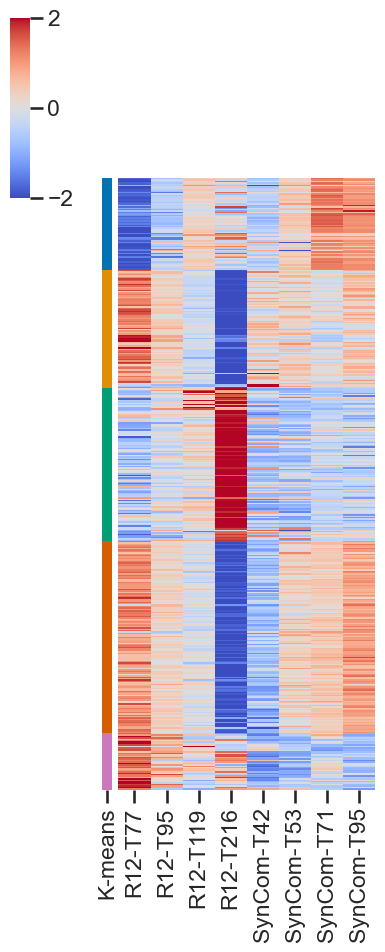

In [201]:
from sklearn.cluster import KMeans
def cluster_genes(df,k=8):
    X = df.values
    km = KMeans(n_clusters=k)
    return km.fit_predict(X)

k=5

zvals=vsd_r12.loc[r12_up_hits+r12_down_hits].drop('SynCom_C_T53_repeat_L1',axis=1).apply(zscore,axis=1)

zvals.columns=pd.MultiIndex.from_tuples([(x.split('_')[0],x.split('_')[2]) for x in zvals.columns])
zvals=zvals.groupby(level=[0,1],axis=1).mean()
r12_order=[(   'R12',  'T77'),
            (   'R12',  'T95'),
            (   'R12', 'T119'),
            (   'R12', 'T216'),
            ('SynCom',  'T42'),
            ('SynCom',  'T53'),
            ('SynCom',  'T71'),
            ('SynCom',  'T95')]
zvals=zvals[r12_order].drop_duplicates()
y_pred = cluster_genes(zvals,k=k)
colors = sns.color_palette('colorblind')
cmap = {zvals.index[i]:colors[y_pred[i]] for i in range(len(zvals.index))}
handles = [mpatches.Patch(color=colors[i], label='Cluster: %s'%(i+1)) for i in range(k)]
zvals['kmeans'] =y_pred
zvals = zvals.sort_values('kmeans').drop('kmeans',axis=1)

row_colors = pd.Series(zvals.index).map(cmap)
row_colors.index=zvals.index
row_colors.name='K-means'

g=sns.clustermap(zvals,cmap='coolwarm',figsize=(4,10),vmin=-2,vmax=2,yticklabels='',row_colors=row_colors,col_cluster=False,row_cluster=False)
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')
#plt.savefig('R12_DEGs_heatmap-KMeans.pdf',bbox_inches='tight')

In [206]:
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests

idx = []
for g in annot_r12.Query:
        ix = list(annot_r12[annot_r12['Query'] == g]['KEGG KO'].dropna().values)
        idx+=ix
kos=[]
for ix in idx:
    ix=ix.split('ko:')[1:]
    ix = [i.replace(',','') for i in ix]
    kos+=ix
pop_pathcounts = kegg[kegg['enzyme KO'].isin(kos)].groupby(by='subpathway').count()
k=len(set(y_pred))
clustdf = pd.DataFrame()
pvals = []
total_pathcounts=pd.DataFrame()
path_annot=pd.DataFrame()
for clust in range(1,k+1):
    #For each cluster get the associated genes"
    genes =  zvals.index[y_pred==clust-1]
    #M is the population size 
    #n is the number of successes in the population 
    #N is the sample size 
    #X is the number of drawn “successes”.
    idx = []
    #For each gene figure out what its position(s) is(are) in the annotation table
    ko_dict={}
    kos=[]
    for g in genes:
        ix = list(annot_r12[annot_r12['Query'] == g]['KEGG KO'].dropna().values)
        if len(ix)==0:
            continue
            ko_dict[g]=np.nan
        ko_dict[g]=[]
        for i in ix:
            i=i.split('ko:')[1:]
            i = [x.replace(',','') for x in i]
            kos+=i
            ko_dict[g]+=i
    #Count how many times each term shows up in table for the set of genes
    pathcounts = kegg[kegg['enzyme KO'].isin(kos)].groupby(by='subpathway').count()
    pathcounts['cluster']=clust
    total_pathcounts=pd.concat([total_pathcounts,pathcounts])
    annot=kegg[kegg['enzyme KO'].isin(kos)]
    annot['cluster']=clust
    path_annot=pd.concat([path_annot,annot])
    
    #Get sample and population size params
    N=pathcounts.superpathway.sum()
    M=pop_pathcounts.superpathway.sum()
    IDs = []
    smp_count =[]
    null_count =[]
    pvals=[]
    #Loop  through each term and test if it's significantly enriched using the hypergeometric test
    for val in pathcounts.index:
        n =pop_pathcounts.loc[val,'superpathway']
        #Don't test terms with less then 3 representative, could be problematic
        if val in IDs or n <3:
            continue
        IDs.append(val)
        x = pathcounts.loc[val,'superpathway']
        smp_count.append(x)
        null_count.append(n)
        pval = hypergeom.sf(x-1, M, n, N)
        pvals.append(pval)
    #Correct p-values
    smp_count=np.array(smp_count)
    null_count=np.array(null_count)
    IDs = np.array(IDs)
    df = pd.DataFrame(np.array([IDs,pvals,len(pvals)*[clust],smp_count,null_count]).T,columns=['name','pval','clust','clust_n','null_n'])
    #df['logp'] = -np.log(df['pval'].astype(float))
    clustdf = pd.concat([clustdf,df],ignore_index=True)
#Format clustdf values and calculate percentage of genes in each category found in the cluster
clustdf['clust_n']=clustdf['clust_n'].astype(float)
clustdf['null_n']=clustdf['null_n'].astype(float)
clustdf['percent'] = clustdf['clust_n']/clustdf['null_n']

clustdf=clustdf.sort_values(by='pval')
rej, pval_corr = multipletests(clustdf['pval'].values.astype(float), method='fdr_bh',alpha=0.01)[:2]
clustdf['pval']=pval_corr
clustdf=clustdf[clustdf['pval']<=0.05]
#clustdf['logp']=np.log(clustdf['pval'].values)
for clust,df in clustdf.groupby(by='clust'):
    genes =  zvals.index[y_pred==int(clust)-1]
    print('Cluster %s: %s\n'%(int(clust),len(genes)))
    for i in df.index.values:
        print(df.loc[i,'name'],df.loc[i,'pval'],df.loc[i,'clust_n'])
    print('\n--------------------------------------------------------')

Cluster 1: 65

Two-component system 0.01110529703910746 15.0
Secretion system 0.0202011858371531 12.0
Flagellar assembly 5.545633105339602e-25 26.0
Valine, leucine and isoleucine biosynthesis 0.00016313680019905695 6.0
Bacterial chemotaxis 7.286095945302834e-09 10.0
Bacterial motility proteins 2.9438735996427177e-30 38.0

--------------------------------------------------------
Cluster 2: 84

Structural 0.028603300802598486 5.0
Ribosome 3.960510749171636e-06 18.0

--------------------------------------------------------
Cluster 3: 108

Mitochondrial biogenesis 0.01110529703910746 8.0
Ribosome 4.329344401921446e-11 28.0

--------------------------------------------------------
Cluster 4: 136

Ribosome 1.1875587125906655e-06 22.0

--------------------------------------------------------
Cluster 5: 40

Ribosome 2.457537295368701e-07 17.0

--------------------------------------------------------


/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/2757423917.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annot['cluster']=clust
/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/2757423917.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annot['cluster']=clust
/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/2757423917.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

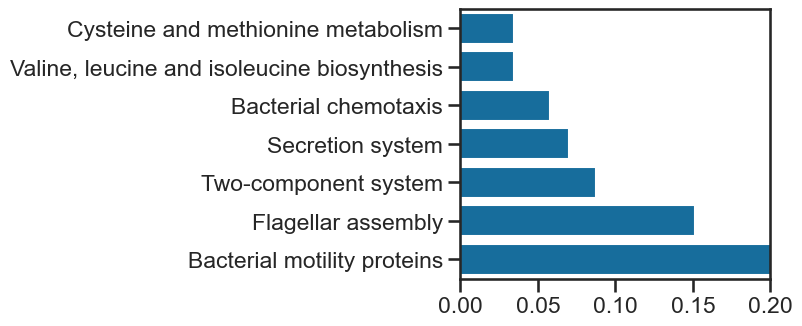

<Figure size 640x480 with 0 Axes>

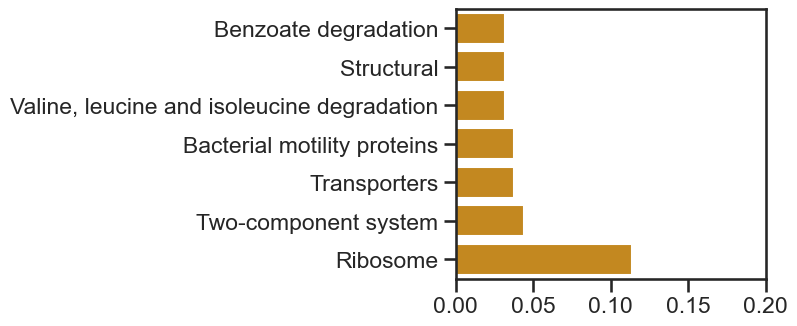

<Figure size 640x480 with 0 Axes>

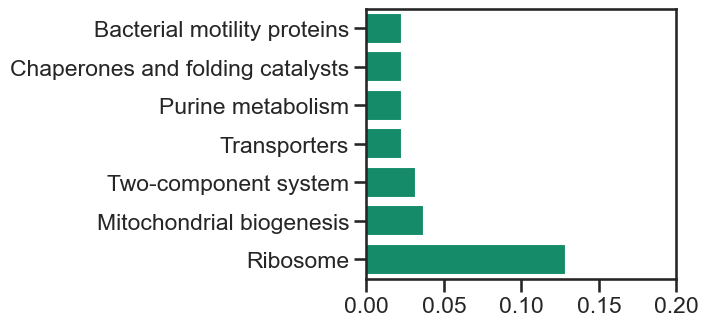

<Figure size 640x480 with 0 Axes>

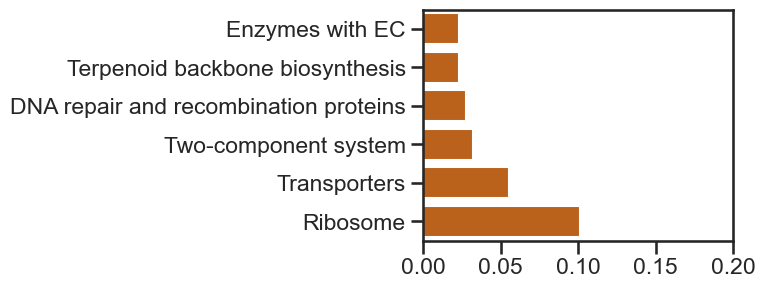

<Figure size 640x480 with 0 Axes>

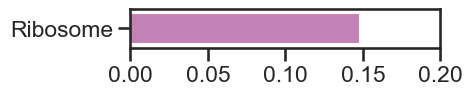

<Figure size 640x480 with 0 Axes>

In [207]:
res=pd.DataFrame()
colors=sns.color_palette('colorblind')
for idx,df in total_pathcounts.groupby(by='cluster'):
    frac=df/df.sum()
    frac=frac[df.pathway>4]
    frac=frac['pathway'].reset_index()
    frac.columns=['pathway','frac']
    frac['cluster']=idx
    res=pd.concat([res,frac],ignore_index=True)
    height=0.5*len(frac)
    plt.figure(figsize=(4,height))
    sns.barplot(y='pathway',x='frac',data=frac.sort_values(by='frac'),color=colors[idx-1])
    plt.xlabel('')
    plt.ylabel('')
    plt.xlim(0,0.2)
    #plt.savefig('R12-Kmeans-barplot-cluster-%s.pdf'%(idx),bbox_inches='tight')
    plt.show()
    plt.clf()

# R12 Hits
* Chemotaxis and cell motility highly upregulated
* Expression of denifrication genes unchanged
* Glycine, serine and threonine metabolism upregulated 
* BCAA biosynthesis active but export unclear
* In general activity appears to pick up occur earlier
* Expression of Nuo, cox, cyd, cco genes suggest oxygen presence initially which is consumed
    * Also suggests transition from oxydative phosphorylation to substrate phosphorylation
    * TCA cycle genes and pyruvate/fermentation suggetion ethanol utilization (making acetate)

In [159]:
genes=[
'nirB',
'nirD',
'nirK',
'nirS',
'nosZ',
'narK',
'narG',
'narJ',
'norR',
'norB',
'norM',
'napF',
'nasA',
'nasD',
'nasE',
'nasF',
'nasT',
'nasR']

denitr_3h11 = annot_3h11[annot_3h11['Preferred_name'].isin(genes)]
denitr_r12 = annot_r12[annot_r12['Preferred_name'].isin(genes)]

denitr_3h11

,Query,Seed ortholog,e-value,score,best tax lvl,Preferred_name,GO terms,EC number,KEGG KO,KEGG pathway,...,KEGG rclass,BRITE,KEGG TC,CAZy,BiGG reaction,annot lvl,matching OGs,Best OG,COG cat,description
19,GW101-3H11_contig_1_20,358220.C380_00080,7.800000e-18,96.3,Bacteria,napF,"GO:0005575,GO:0005622,GO:0005623,GO:0005737,GO...",NaN,ko:K02572,NaN,...,NaN,ko00000,NaN,NaN,NaN,Bacteria,"COG1145@1,COG1145@2",NA|NA|NA,C,"4fe-4S ferredoxin, iron-sulfur binding domain ..."
195,GW101-3H11_contig_1_216,358220.C380_00920,1.100000e-241,842.4,Comamonadaceae,norR,NaN,NaN,"ko:K02584,ko:K12146,ko:K12266","ko02020,ko05132,map02020,map05132",...,NaN,"ko00000,ko00001,ko03000",NaN,NaN,NaN,Bacteria,"1QTT3@1224,2VJYJ@28216,4AAXJ@80864,COG3604@1,C...",NA|NA|NA,K,PFAM sigma-54 factor interaction domain-contai...
196,GW101-3H11_contig_1_217,358220.C380_00925,0.000000e+00,1479.9,Comamonadaceae,norB,NaN,1.7.2.5,ko:K04561,"ko00910,ko01120,map00910,map01120",...,RC02794,"ko00000,ko00001,ko00002,ko01000",3.D.4.10,NaN,NaN,Bacteria,"1MVT1@1224,2VHXU@28216,4ACAW@80864,COG3256@1,C...",NA|NA|NA,P,Cytochrome C and Quinol oxidase polypeptide I
489,GW101-3H11_contig_1_519,1276756.AUEX01000012_gene3602,1.000000e-262,912.1,Comamonadaceae,narK,NaN,NaN,ko:K02575,"ko00910,map00910",...,NaN,"ko00000,ko00001,ko00002,ko02000",2.A.1.8,NaN,NaN,Bacteria,"1MU27@1224,2VI5E@28216,4ABQV@80864,COG2223@1,C...",NA|NA|NA,P,nitrite transporter
490,GW101-3H11_contig_1_520,1276756.AUEX01000012_gene3601,0.000000e+00,2625.5,Comamonadaceae,narG,"GO:0005575,GO:0005623,GO:0005886,GO:0016020,GO...",1.7.5.1,"ko:K00370,ko:K17050","ko00910,ko01120,ko02020,map00910,map01120,map0...",...,RC02812,"ko00000,ko00001,ko00002,ko01000,ko02000","5.A.3.1,5.A.3.8",NaN,NaN,Bacteria,"1MW9S@1224,2VJ2F@28216,4A9MX@80864,COG5013@1,C...",NA|NA|NA,C,Belongs to the prokaryotic molybdopterin-conta...
492,GW101-3H11_contig_1_522,358220.C380_02350,1.500000e-121,442.2,Comamonadaceae,narJ,"GO:0001666,GO:0003674,GO:0005575,GO:0005622,GO...",1.7.5.1,"ko:K00370,ko:K00373,ko:K17052","ko00910,ko01120,ko02020,map00910,map01120,map0...",...,RC02812,"ko00000,ko00001,ko00002,ko01000,ko02000","5.A.3.1,5.A.3.8",NaN,"iE2348C_1286.E2348C_1350,iECABU_c1320.ECABU_c1...",Bacteria,"1MY4E@1224,2VQI7@28216,4ACPP@80864,COG2180@1,C...",NA|NA|NA,C,TIGRFAM nitrate reductase molybdenum cofactor ...
1296,GW101-3H11_contig_1_1394,1268622.AVS7_01313,0.000000e+00,1180.2,Comamonadaceae,nosZ,"GO:0000041,GO:0005575,GO:0005623,GO:0006810,GO...","1.7.2.4,1.9.3.1","ko:K00376,ko:K02275","ko00190,ko00910,ko01100,ko01120,map00190,map00...",...,"RC00016,RC02861","ko00000,ko00001,ko00002,ko01000","3.D.4.2,3.D.4.4,3.D.4.6",NaN,NaN,Bacteria,"1MVIH@1224,2VM8J@28216,4ABMS@80864,COG4263@1,C...",NA|NA|NA,C,Cytochrome c oxidase subunit
1551,GW101-3H11_contig_1_1670,358220.C380_17500,0.000000e+00,1783.5,Comamonadaceae,nasA,NaN,1.7.7.2,"ko:K00367,ko:K00372","ko00910,ko01120,map00910,map01120",...,RC02812,"ko00000,ko00001,ko00002,ko01000",NaN,NaN,NaN,Bacteria,"1NS3T@1224,2VIB1@28216,4AB7E@80864,COG0243@1,C...",NA|NA|NA,C,Belongs to the prokaryotic molybdopterin-conta...
1552,GW101-3H11_contig_1_1671,358220.C380_17495,1.300000e-64,252.3,Comamonadaceae,nirD,NaN,1.7.1.15,"ko:K00363,ko:K05710,ko:K14578,ko:K18087","ko00360,ko00621,ko00624,ko00626,ko00627,ko0063...",...,"RC00091,RC00098,RC00157,RC00176,RC00274,RC0027...","br01602,ko00000,ko00001,ko00002,ko01000",NaN,NaN,"iSB619.SA_RS12545,iYO844.BSU03290",Bacteria,"1N03R@1224,2VSP4@28216,4AEC0@80864,COG2146@1,C...",NA|NA|NA,P,"TIGRFAM nitrite reductase NAD(P)H , small subunit"
1554,GW101-3H11_contig_1_1673,358220.C380_17485,0.000000e+00,1604.0,Comamonadaceae,nirB,NaN,1.7.1.15,ko:K00362,"ko00910,ko01120,map00910,map01120",...,RC00176,"ko00000,ko00001,ko00002,ko01000",NaN,NaN,NaN,Bacteria,"1MW58@1224,2VIEA@28216,4AA8E@80864,COG1251@1,C...",NA|NA|NA,C,"nitrite sulfite reductase, hemoprotein beta-co..."


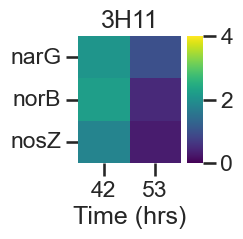

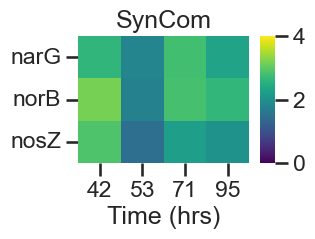

In [160]:
genes = ['narG','norB','nosZ']
df=logtpm[tpm.target_id.isin(list(denitr_3h11.Query.values)+list(denitr_r12.Query.values))][['logtpm','cond','rep','time','target_id']]
df.time=df.time.astype(int)
df=df.pivot_table(index=['cond','time'],columns='target_id',values='logtpm')
zvals=df.apply(zscore)
h11=df.loc[['3H11','SynCom'],[x for x in df.columns if '3H11' in x]]
gene_dict=denitr_3h11.loc[:,['Query','Preferred_name']]
gene_dict.index=gene_dict.Query
gene_dict=gene_dict['Preferred_name'].to_dict()
h11.columns=h11.columns.map(gene_dict)
h11=h11.drop([('3H11',71),('3H11',95),('SynCom',142)],axis=0)
scale=0.55
for label in ['3H11','SynCom']:

    figsize=(np.array(h11.loc[label,genes].T.shape)[::-1]+np.array([1,0]))*scale
    plt.figure(figsize=figsize)
    sns.heatmap(h11.loc[label,genes].T,cmap='viridis',vmin=0,vmax=4,cbar_kws={"shrink": 1,"aspect":8})
    plt.yticks(rotation=0)
    plt.ylabel('')
    plt.xlabel('Time (hrs)')
    plt.title(label)
    #plt.savefig(label+'-3H11-Denitr-Genes-logTPM-v1.png',dpi=500,bbox_inches='tight')


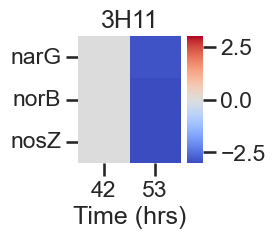

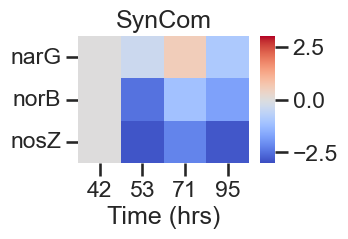

In [161]:
genes = ['narG','norB','nosZ']
df=tpm[tpm.target_id.isin(list(denitr_3h11.Query.values)+list(denitr_r12.Query.values))][['tpm','cond','rep','time','target_id']]
df.time=df.time.astype(int)
df=df.pivot_table(index=['cond','time'],columns='target_id',values='tpm')
zvals=df.apply(zscore)
h11=df.loc[['3H11','SynCom'],[x for x in df.columns if '3H11' in x]]
gene_dict=denitr_3h11.loc[:,['Query','Preferred_name']]
gene_dict.index=gene_dict.Query
gene_dict=gene_dict['Preferred_name'].to_dict()
h11.columns=h11.columns.map(gene_dict)
h11=h11.drop([('3H11',71),('3H11',95),('SynCom',142)],axis=0)
scale=0.55
for label in ['3H11','SynCom']:

    figsize=(np.array(h11.loc[label,genes].T.shape)[::-1]+np.array([1,0]))*scale
    plt.figure(figsize=figsize)
    tmp=h11.loc[label,genes].T
    tmp=np.log2(tmp.divide(tmp.iloc[:,0].values,axis=0))
    sns.heatmap(tmp,cmap='coolwarm',cbar_kws={"shrink": 1,"aspect":8},vmax=3,vmin=-3)
    plt.yticks(rotation=0)
    plt.ylabel('')
    plt.xlabel('Time (hrs)')
    plt.title(label)
    #plt.savefig(label+'-3H11-Denitr-Genes-logTPM-v1.png',dpi=500,bbox_inches='tight')


In [162]:
df_err=df.groupby(level=[0,1],axis=0).std()
df=df.groupby(level=[0,1],axis=0).mean()
genes = ['narG','norB','nosZ']
gene_dict=denitr_3h11.loc[:,['Query','Preferred_name']]
gene_dict.index=gene_dict.Query
gene_dict=gene_dict['Preferred_name'].to_dict()
h11 = df.copy()
h11.columns=h11.columns.map(gene_dict)
h11=h11.drop([('SynCom',142),('3H11',71),('3H11',95)],axis=0)

h11_err = df_err.copy()
h11_err.columns=h11_err.columns.map(gene_dict)
h11_err=h11_err.drop([('SynCom',142),('3H11',71),('3H11',95)],axis=0)



/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/3237774491.py:1: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  df_err=df.groupby(level=[0,1],axis=0).std()
/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/3237774491.py:2: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  df=df.groupby(level=[0,1],axis=0).mean()


/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/2626236681.py:7: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  df_err=df.groupby(level=[0,1],axis=0).std()
/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/2626236681.py:8: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  df=df.groupby(level=[0,1],axis=0).mean()


(2.5, 4.15)

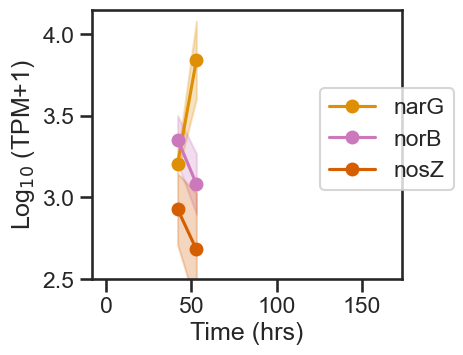

In [163]:
df=tpm[(tpm.target_id.isin(annot_3h11.Query))&(~tpm.target_id.isin(nc_genes))]
df=df[df.cond.isin(['3H11','SynCom'])]
df=df.pivot(columns='target_id',index='sample',values='tpm')
df=df.divide(df.sum(axis=1),axis=0)*10**6
df=np.log10(df+1)
df.index=pd.MultiIndex.from_tuples([(x.split('_')[1],int(x.split('_')[-3][1:]))for x in df.index])
df_err=df.groupby(level=[0,1],axis=0).std()
df=df.groupby(level=[0,1],axis=0).mean()
genes = ['narG','norB','nosZ']
gene_dict=denitr_3h11.loc[:,['Query','Preferred_name']]
gene_dict.index=gene_dict.Query
gene_dict=gene_dict['Preferred_name'].to_dict()
h11 = df.copy()
h11.columns=h11.columns.map(gene_dict)
h11=h11.drop([('SynCom',142),('3H11',71),('3H11',95)],axis=0)

h11_err = df_err.copy()
h11_err.columns=h11_err.columns.map(gene_dict)
h11_err=h11_err.drop([('SynCom',142),('3H11',71),('3H11',95)],axis=0)


fig,ax1 = plt.subplots(1,1,figsize=(4,3.5))
i=1
color_map={'narG':colors[1],'nirK':colors[2],'norB':colors[4],'nosZ':colors[3]}
for g in genes:
    vals=h11.loc['3H11',g]
    vals_err=h11_err.loc['3H11',g]
    ax1.plot(vals.index.astype(int),vals.values,marker='o',label=g,color=color_map[g])
    ax1.fill_between(vals.index.astype(int),vals.values-vals_err.values,vals.values+vals_err.values,color=color_map[g],alpha=0.25)
    i+=1
ax1.set_xlim((-8.25, 173.25))
ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel('Log$_{10}$ (TPM+1)')
ax1.legend(bbox_to_anchor=(.7,.75))
ax1.set_ylim((2.5, 4.15))

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/2788041608.py:7: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  df_err=df.groupby(level=[0,1],axis=0).std()
/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/2788041608.py:8: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  df=df.groupby(level=[0,1],axis=0).mean()


(0.0, 3.0)

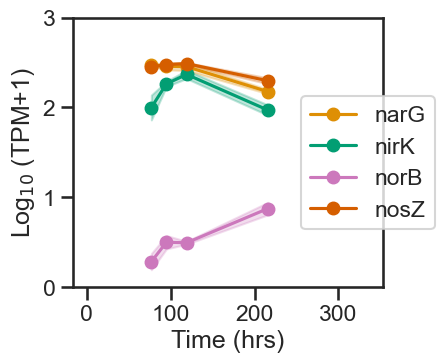

In [164]:
df=tpm[(tpm.target_id.isin(annot_r12.Query))&(~tpm.target_id.isin(nc_genes))]
df=df[df.cond.isin(['R12','SynCom'])]
df=df.pivot(columns='target_id',index='sample',values='tpm')
df=df.divide(df.sum(axis=1),axis=0)*10**6
df=np.log10(df+1)
df.index=pd.MultiIndex.from_tuples([(x.split('_')[1],int(x.split('_')[-3][1:]))for x in df.index])
df_err=df.groupby(level=[0,1],axis=0).std()
df=df.groupby(level=[0,1],axis=0).mean()
genes = ['narG','nirK','norB','nosZ']
gene_dict=denitr_r12.loc[:,['Query','Preferred_name']]
gene_dict.index=gene_dict.Query
gene_dict=gene_dict['Preferred_name'].to_dict()
r12 = df.copy()
r12.columns=r12.columns.map(gene_dict)
r12=r12.drop([('SynCom',142)],axis=0)

r12_err = df_err.copy()
r12_err.columns=r12_err.columns.map(gene_dict)
r12_err=r12_err.drop([('SynCom',142),],axis=0)


fig,ax1 = plt.subplots(1,1,figsize=(4,3.5))
i=1
color_map={'narG':colors[1],'nirK':colors[2],'norB':colors[4],'nosZ':colors[3]}
for j in range(len(genes)):
    g=genes[j]
    vals=r12.loc['R12',:].iloc[:,j]
    vals_err=r12_err.loc['R12',:].iloc[:,j]
    ax1.plot(vals.index.astype(int),vals.values,marker='o',label=g,color=color_map[g])
    ax1.fill_between(vals.index.astype(int),vals.values-vals_err.values,vals.values+vals_err.values,color=color_map[g],alpha=0.25)
    i+=1
ax1.set_xlim((-8.25, 173.25))
ax1.set_xlim((-16.8, 352.8))
ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel('Log$_{10}$ (TPM+1)')
ax1.legend(bbox_to_anchor=(.7,.75))
ax1.set_ylim((0,3))


/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/3156066515.py:7: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  df=df.groupby(level=[0,1],axis=0).mean()


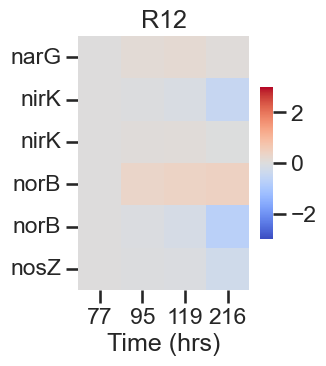

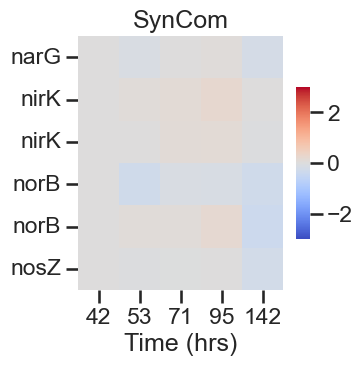

In [165]:
df=tpm[(tpm.target_id.isin(annot_r12.Query))&(~tpm.target_id.isin(nc_genes))]
df=df[df.cond.isin(['R12','SynCom'])]
df=df.pivot(columns='target_id',index='sample',values='tpm')
df=df.divide(df.sum(axis=1),axis=0)*10**6
df=np.log10(df+1)
df.index=pd.MultiIndex.from_tuples([(x.split('_')[1],int(x.split('_')[-3][1:]))for x in df.index])
df=df.groupby(level=[0,1],axis=0).mean()

genes=['narG','nirK','norB','nosZ']
gene_dict=denitr_r12.loc[:,['Query','Preferred_name']]
gene_dict.index=gene_dict.Query
gene_dict=gene_dict['Preferred_name'].to_dict()
r12 = df.copy()
r12.columns=r12.columns.map(gene_dict)
scale=0.55
for label in ['R12','SynCom']:
    figsize=(np.array(r12.loc[label,genes].T.shape)[::-1]+np.array([1,0]))*scale
    plt.figure(figsize=figsize)
    tmp=r12.loc[label,genes].T
    tmp=np.log2(tmp.divide(tmp.iloc[:,0].values,axis=0))
    sns.heatmap(tmp,cmap='coolwarm',cbar_kws={"shrink": .60,"aspect":11},vmax=3,vmin=-3)
    plt.yticks(rotation=0)
    plt.ylabel('')
    plt.xlabel('Time (hrs)')
    plt.title(label)
    #plt.savefig(label+'-R12-Denitr-Genes-logTPM.png',dpi=500,bbox_inches='tight')

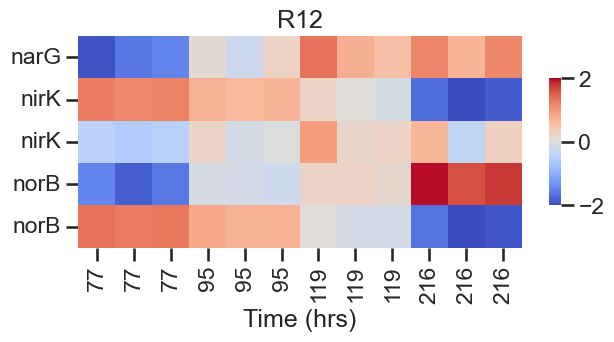

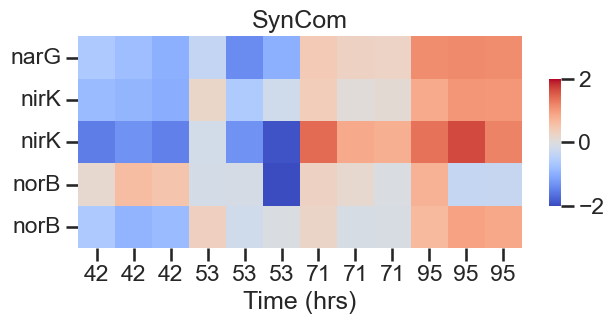

In [166]:
df=vsd_r12.T.copy()
df.index=pd.MultiIndex.from_tuples([(x.split('_')[0],int(x.split('_')[2][1:])) for x in df.index])
#df=df.groupby(level=[0,1]).mean().apply(zscore)
df=df.apply(zscore)

genes=['narG','nirK','norB']
gene_dict=denitr_r12.loc[:,['Query','Preferred_name']]
gene_dict.index=gene_dict.Query
gene_dict=gene_dict['Preferred_name'].to_dict()
r12 = df.copy()
r12.columns=r12.columns.map(gene_dict)
r12=r12[genes]
scale=0.55
for label in ['R12','SynCom']:
    figsize=(np.array(r12.loc[label,genes].T.shape)[::-1]+np.array([1,0]))*scale
    plt.figure(figsize=figsize)
    tmp=r12.loc[label,genes].T
    sns.heatmap(tmp,cmap='coolwarm',cbar_kws={"shrink": .60,"aspect":11},vmax=2,vmin=-2)
    plt.yticks(rotation=0)
    plt.ylabel('')
    plt.xlabel('Time (hrs)')
    plt.title(label)
    #plt.savefig(label+'-R12-Denitr-Genes-logTPM.pdf',bbox_inches='tight')

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/36573035.py:9: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(x='time',y='z-score',hue='org',data=d,color='k',alpha=0.5,dodge=True)


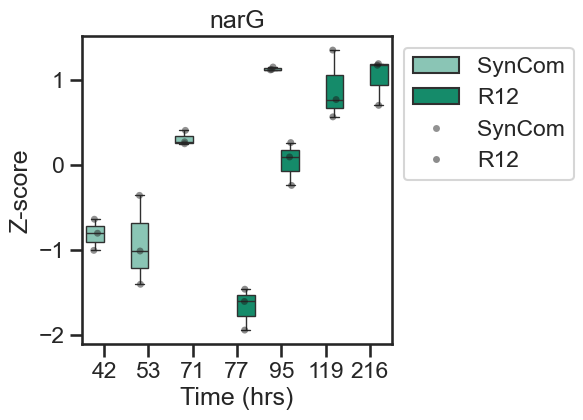

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/36573035.py:9: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(x='time',y='z-score',hue='org',data=d,color='k',alpha=0.5,dodge=True)


<Figure size 640x480 with 0 Axes>

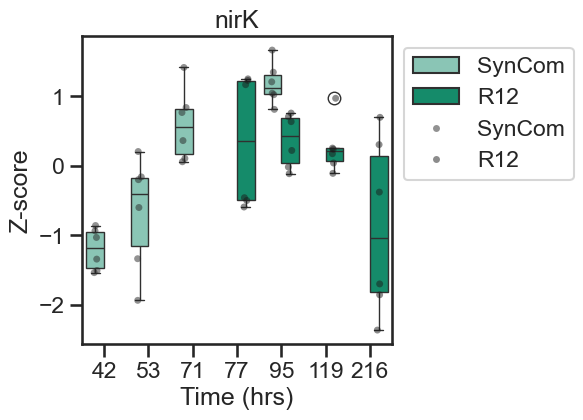

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/36573035.py:9: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(x='time',y='z-score',hue='org',data=d,color='k',alpha=0.5,dodge=True)


<Figure size 640x480 with 0 Axes>

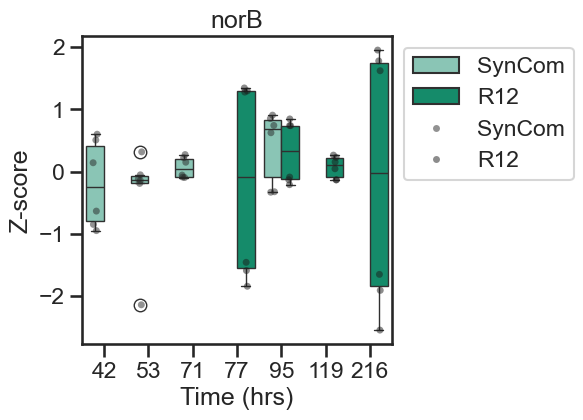

<Figure size 640x480 with 0 Axes>

In [175]:
df=r12.stack().reset_index()
colors=sns.color_palette('colorblind')
colors=[colors[2]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)
df.columns=['org','time','gene','z-score']
for idx, d in df. groupby(by='gene'):
    plt.figure(figsize=(4,4))
    sns.boxplot(x='time',y='z-score',hue='org',data=d,palette=[colors[1],colors[0]])
    sns.stripplot(x='time',y='z-score',hue='org',data=d,color='k',alpha=0.5,dodge=True)
    plt.title(idx)
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlabel('Time (hrs)')
    plt.ylabel('Z-score')
    #plt.savefig('R12-Boxplot-%s.pdf'%idx,bbox_inches='tight')
    plt.show()
    plt.clf()

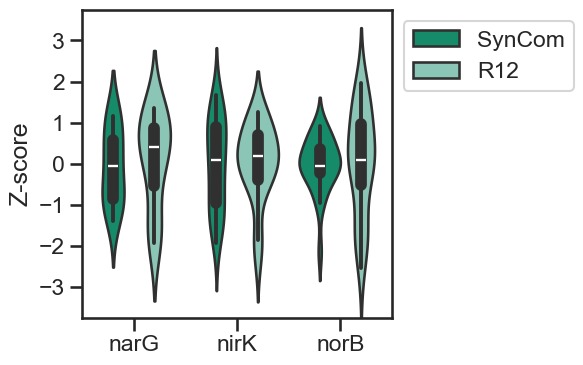

narG TtestResult(statistic=0.34491554999524426, pvalue=0.7335963568289425, df=20.95136521672214)
nirK TtestResult(statistic=0.16279745385043462, pvalue=0.8714055457687961, df=45.0774555419891)
norB TtestResult(statistic=0.17350868462886176, pvalue=0.8632605826607473, df=34.674142329811026)


<Figure size 640x480 with 0 Axes>

In [176]:
genes=['narG','nirK','norB']
df=r12.stack().reset_index()
df.columns=['org','time','gene','z-score']
df=df[df.gene.isin(genes)]
colors=sns.color_palette('colorblind')
colors=[colors[2]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)

    
plt.figure(figsize=(4,4))
sns.violinplot(x='gene',y='z-score',hue='org',data=df,palette=[colors[0],colors[1]],order=genes)
#sns.stripplot(x='gene',y='z-score',hue='org',data=df,color='k',alpha=0.5,dodge=True,order=genes)
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Z-score')
plt.xlabel('')
plt.ylim(-3.75,3.75)
plt.yticks([3,2,1,0,-1,-2,-3])
#plt.savefig('R12-denitr-violinplots.pdf',bbox_inches='tight')
plt.show()
plt.clf()

for g in ['narG','nirK','norB']:
    x1=df[(df.org=='R12')&(df.gene==g)]['z-score'].values
    x2=df[(df.org=='SynCom')&(df.gene==g)]['z-score'].values
    print(g,ttest_ind(x1,x2,equal_var=False))

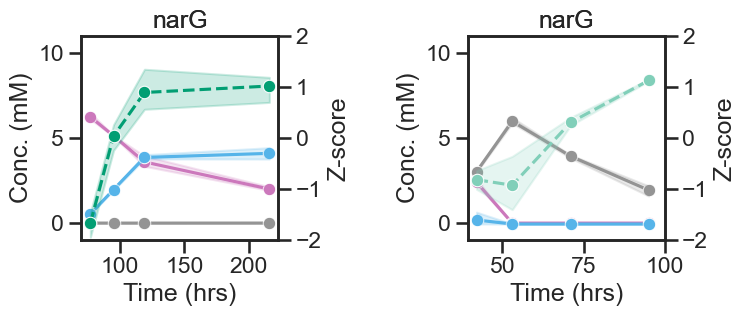

<Figure size 640x480 with 0 Axes>

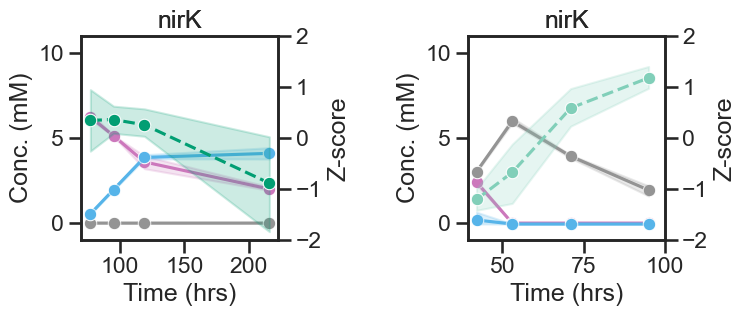

<Figure size 640x480 with 0 Axes>

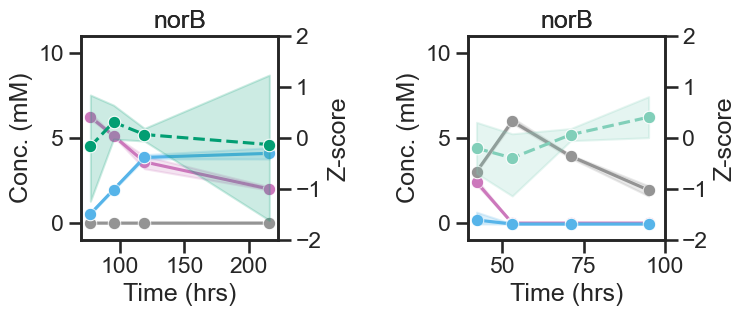

<Figure size 640x480 with 0 Axes>

In [177]:
sns.set(context= 'talk',style='ticks',font_scale=1,rc ={'axes.spines.right': True,'axes.spines.top': True},palette='colorblind')
colors=sns.color_palette('colorblind')
colors=[colors[2]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)

colors2=sns.color_palette('colorblind')
colors2=[colors2[4],colors2[7],colors2[9]]

for idx, d in df. groupby(by='gene'):
    if idx not in genes:
        continue
    fig,ax = plt.subplots(1,2,figsize=(8,3.5))
    ax2=[]
    i=0
    xtick_sets=[[100,150,200],[50,75,100]]
    for org in ['R12','SynCom']:
        
        ax2.append(ax[i].twinx())
        j=0
        for chem in ['nitrate(mM)','nitrite(mM)']:
            sns.lineplot(x='hrs',y=chem,data=gallery[(gallery.condition == org)&(gallery.hrs.isin(d[d.org==org].time))],marker='o',color=colors2[j],ax=ax[i],label=None,zorder=1)
            j+=1
        sns.lineplot(x='hrs',y='nitrous oxide (mM)',data=gc[(gc.condition == org)&(gc.hrs.isin(d[d.org==org].time))],marker='o',color=colors2[j],ax=ax[i],label=None,zorder=1)
        sns.lineplot(x='time',y='z-score',data=d[d.org==org],color=colors[i],marker='o',ax=ax2[i],label=None,linestyle='--')
        ax2[i].set_ylim(-2,2)
        ax2[i].set_title(idx)
        ax2[i].set_ylabel('Z-score')
        ax2[i].set_xlabel('Time (hrs)')
        ax[i].set_xlabel('Time (hrs)')
        ax[i].set_ylabel('Conc. (mM)')
        ax[i].set_ylim(-1,11)
        ax[i].set_title(idx)
        ax[i].set_xticks(xtick_sets[i])
        i+=1
       

    plt.tight_layout()
    #plt.savefig('SynCom-R12-%s-lineplot+chems.pdf'%(idx),bbox_inches='tight')
    
    plt.show()
    plt.clf()

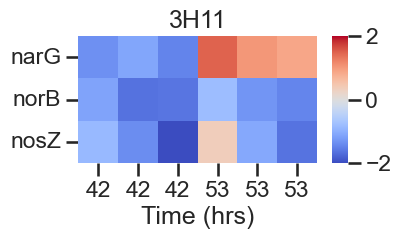

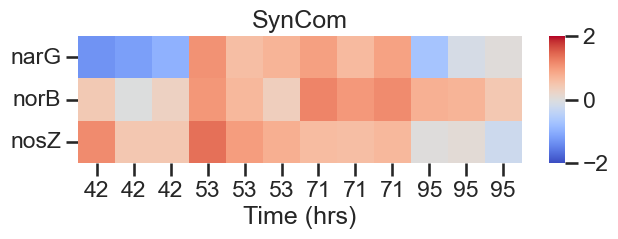

In [169]:
df=vsd_3h11.T.copy()
df.index=pd.MultiIndex.from_tuples([(x.split('_')[0],int(x.split('_')[2][1:])) for x in df.index])
#df=df.groupby(level=[0,1]).mean()

genes = ['narG','norB','nosZ']
gene_dict=denitr_3h11.loc[:,['Query','Preferred_name']]
gene_dict.index=gene_dict.Query
gene_dict=gene_dict['Preferred_name'].to_dict()
h11 = df.copy()
h11.columns=h11.columns.map(gene_dict)
zvals=h11.apply(zscore)

scale=0.55

for label in ['3H11','SynCom']:

    figsize=(np.array(zvals.loc[label,genes].T.shape)[::-1]+np.array([1,0]))*scale
    plt.figure(figsize=figsize)
    sns.heatmap(zvals.loc[label,genes].T,cmap='coolwarm',vmin=-2,vmax=2,cbar_kws={"shrink": 1,"aspect":8})
    plt.yticks(rotation=0)
    plt.ylabel('')
    plt.xlabel('Time (hrs)')
    plt.title(label)
    #plt.savefig(label+'-3H11-Denitr-Genes-LogTPM-Zscore-v1.pdf',bbox_inches='tight')

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/982238599.py:11: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(x='time',y='z-score',hue='org',data=d,color='k',alpha=0.5,dodge=True)


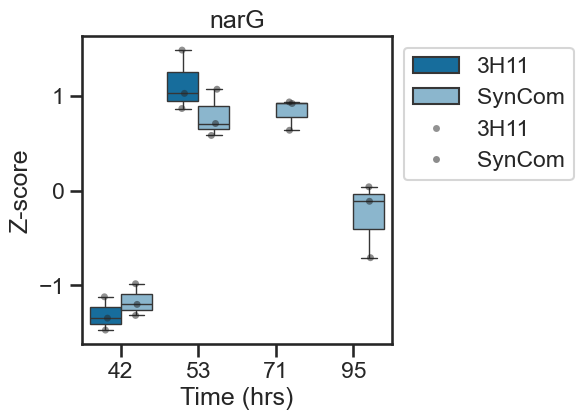

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/982238599.py:11: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(x='time',y='z-score',hue='org',data=d,color='k',alpha=0.5,dodge=True)


<Figure size 640x480 with 0 Axes>

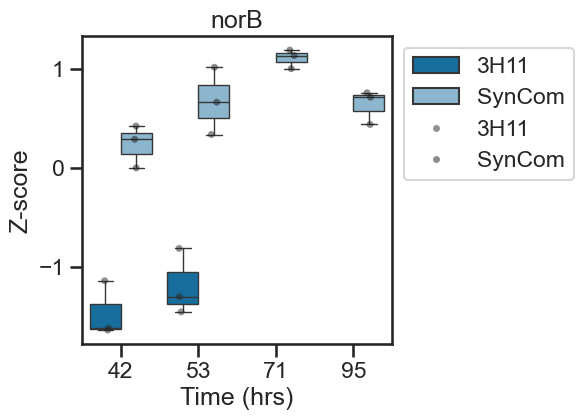

/var/folders/06/47zwkw994h38rfpphgtmmm380000gq/T/ipykernel_22708/982238599.py:11: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(x='time',y='z-score',hue='org',data=d,color='k',alpha=0.5,dodge=True)


<Figure size 640x480 with 0 Axes>

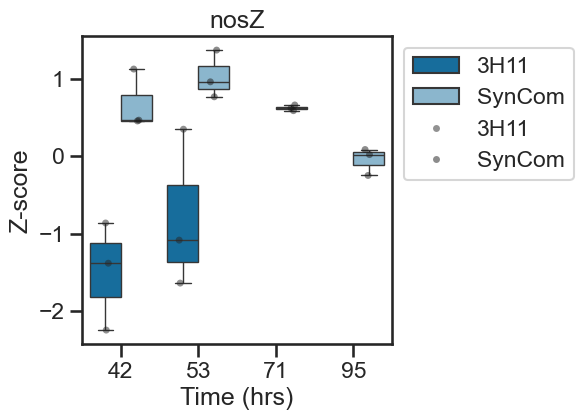

<Figure size 640x480 with 0 Axes>

In [170]:

df=zvals.stack().reset_index()
df.columns=['org','time','gene','z-score']
colors=sns.color_palette('colorblind')
colors=[colors[0]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)
for idx, d in df. groupby(by='gene'):
    if idx not in genes:
        continue
    plt.figure(figsize=(4,4))
    sns.boxplot(x='time',y='z-score',hue='org',data=d,palette=[colors[0],colors[1]])
    sns.stripplot(x='time',y='z-score',hue='org',data=d,color='k',alpha=0.5,dodge=True)
    plt.title(idx)
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlabel('Time (hrs)')
    plt.ylabel('Z-score')
    plt.savefig('3H11-Boxplot-%s.pdf'%idx,bbox_inches='tight')
    plt.show()
    plt.clf()

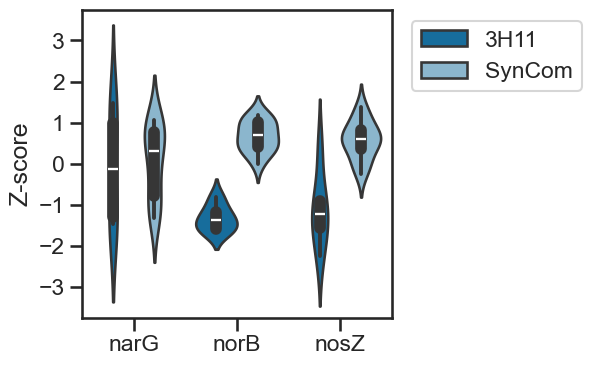

narG TtestResult(statistic=-0.23164813363837922, pvalue=0.8232199399911799, df=7.24332223961227)
norB TtestResult(statistic=-11.837929699178337, pvalue=6.305767259879771e-08, df=11.865642716038016)
nosZ TtestResult(statistic=-4.4997110695592095, pvalue=0.003423947145785398, df=6.456430760735397)


<Figure size 640x480 with 0 Axes>

In [171]:
genes = ['narG','norB','nosZ']
df=zvals.stack().reset_index()
df.columns=['org','time','gene','z-score']
df=df[df.gene.isin(genes)]
colors=sns.color_palette('colorblind')
colors=[colors[0]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)

    
plt.figure(figsize=(4,4))
sns.violinplot(x='gene',y='z-score',hue='org',data=df,palette=[colors[0],colors[1]],order=['narG','norB','nosZ'])
#sns.stripplot(x='gene',y='z-score',hue='org',data=df,color='k',alpha=0.5,dodge=True,order=['narG','norB','nosZ'])
plt.legend(bbox_to_anchor=(1.65,1))
plt.xlabel('')
plt.ylabel('Z-score')
plt.ylim(-3.75,3.75)
plt.yticks([3,2,1,0,-1,-2,-3])
plt.savefig('3H11-denitr-violinplots.pdf',bbox_inches='tight')
plt.show()
plt.clf()

for g in ['narG','norB','nosZ']:
    x1=df[(df.org=='3H11')&(df.gene==g)]['z-score'].values
    x2=df[(df.org=='SynCom')&(df.gene==g)]['z-score'].values
    print(g,ttest_ind(x1,x2,equal_var=False))

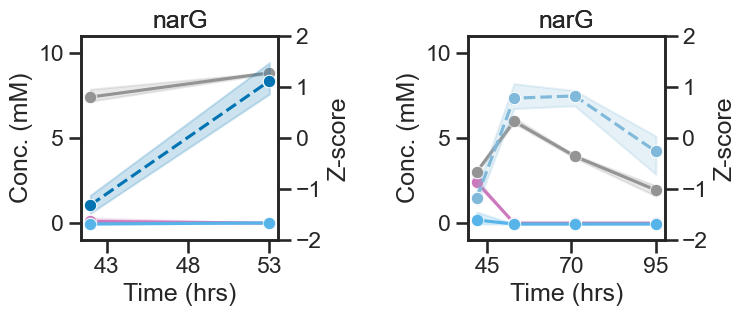

<Figure size 640x480 with 0 Axes>

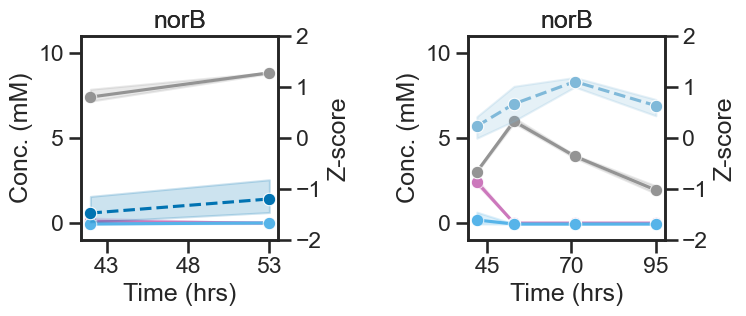

<Figure size 640x480 with 0 Axes>

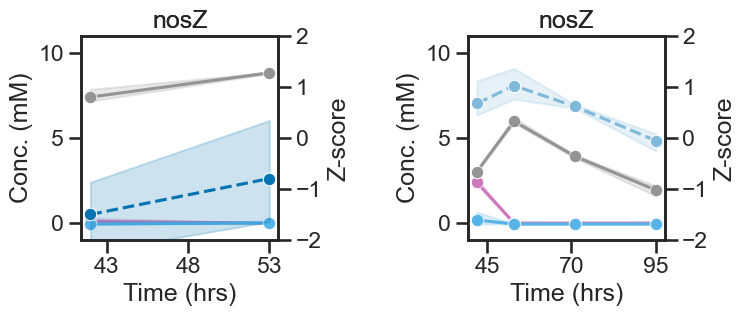

<Figure size 640x480 with 0 Axes>

In [174]:
sns.set(context= 'talk',style='ticks',font_scale=1,rc ={'axes.spines.right': True,'axes.spines.top': True},palette='colorblind')

df=zvals.stack().reset_index()
df.columns=['org','time','gene','z-score']
colors=sns.color_palette('colorblind')
colors=[colors[0]]
colors.append((np.array(colors[0])*255*0.5+np.array([255,255,255])*.5)/255)

colors2=sns.color_palette('colorblind')
colors2=[colors2[4],colors2[7],colors2[9]]

for idx, d in df. groupby(by='gene'):
    if idx not in genes:
        continue
    fig,ax = plt.subplots(1,2,figsize=(8,3.5))
    ax2=[]
    i=0
    xtick_sets=[[43,48,53],[45,70,95]]
    for org in ['3H11','SynCom']:
        ax2.append(ax[i].twinx())
        j=0
        for chem in ['nitrate(mM)','nitrite(mM)']:
            sns.lineplot(x='hrs',y=chem,data=gallery[(gallery.condition == org)&(gallery.hrs.isin(d[d.org==org].time))],marker='o',color=colors2[j],ax=ax[i],label=None,zorder=1)
            j+=1
        sns.lineplot(x='hrs',y='nitrous oxide (mM)',data=gc[(gc.condition == org)&(gc.hrs.isin(d[d.org==org].time))],marker='o',color=colors2[j],ax=ax[i],label=None,zorder=1)
        sns.lineplot(x='time',y='z-score',data=d[d.org==org],color=colors[i],marker='o',ax=ax2[i],label=None,linestyle='--')
        ax2[i].set_ylim(-2,2)
        ax2[i].set_title(idx)
        ax2[i].set_ylabel('Z-score')
        ax2[i].set_xlabel('Time (hrs)')
        ax[i].set_ylabel('Conc. (mM)')
        ax[i].set_ylim(-1,11)
        ax[i].set_title(idx)
        ax[i].set_xlabel('Time (hrs)')
        ax[i].set_xticks(xtick_sets[i])
        i+=1
       

    plt.tight_layout()
    #plt.savefig('SynCom-3H11-%s-lineplot+chems.pdf'%(idx),bbox_inches='tight')
    
    plt.show()
    plt.clf()